# 📰 Comparison of Embedding Models for Clustering Findlay Newsroom Articles
**Goal:** discover themes in 1000+ UF Newsroom posts using embeddings (Word2Vec, GloVe, BERT) and clustering (K-Means, Hierarchical), then evaluate with Silhouette and Davies–Bouldin.


###  Environment Setup  
- Install required libraries for **scraping, NLP, embeddings, clustering, and visualization**.  
- Pin library versions to ensure reproducibility.  


In [202]:
import requests   # For sending HTTP requests to fetch web pages
from bs4 import BeautifulSoup   # For parsing and extracting data from HTML
import pandas as pd   # For handling and analyzing structured data (DataFrames)
import numpy as np   # For numerical computations and arrays
import re   # For regular expressions (text cleaning/pattern matching)
import string   # For string operations like punctuation removal
import nltk   # Natural Language Toolkit for text preprocessing
from nltk.corpus import stopwords   # List of common stopwords to remove from text
from nltk.tokenize import word_tokenize   # For splitting text into tokens (words)
from collections import Counter   # For counting word frequencies and occurrences
from tqdm import tqdm   # For progress bars in loops
import csv   # For reading/writing CSV files
import time   # For adding delays, measuring runtime, etc.
import matplotlib.pyplot as plt   # For creating plots and visualizations
import seaborn as sns   # For statistical data visualization with style
from sklearn.feature_extraction.text import TfidfVectorizer   # For converting text into TF-IDF feature vectors
from sklearn.cluster import KMeans, AgglomerativeClustering   # For clustering algorithms (KMeans, Hierarchical)
from sklearn.metrics import silhouette_score, davies_bouldin_score   # For cluster evaluation metrics
from sklearn.decomposition import PCA   # For dimensionality reduction (principal component analysis)
from sklearn.manifold import TSNE   # For dimensionality reduction & visualization using t-SNE
import umap.umap_ as umap   # For dimensionality reduction using UMAP (faster & scalable)

# ✅ NLTK Downloads (stopwords and tokenizer)
nltk.download("stopwords")   # Download stopwords list
nltk.download("punkt");   # Download tokenizer models


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROHITH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ROHITH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [204]:
pip install umap-learn  

Note: you may need to restart the kernel to use updated packages.


In [206]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 325.1 kB/s eta 0:00:40
     --------------------------------------- 0.1/12.8 MB 573.4 kB/s eta 0:00:23
      --------------------------------------- 0.2/12.8 MB 1.1 MB/s eta 0:00:12
      --------------------------------------- 0.3/12.8 MB 1.4 MB/s eta 0:00:09
     - -------------------------------------- 0.5/12.8 MB 2.0 MB/s eta 0:00:06
     -- ------------------------------------- 0.7/12.8 MB 2.2 MB/s eta 0:00:06
     -- ------------------------------------- 1.0/12.8 MB 2.6 MB/s eta 0:00:05
     --- ------------------------------------ 1.2/12.8 MB 2.9 MB/s eta 0:00:05
     ---- ----------------------------------- 1.4/12.8 MB 3.1 MB/s eta 0:00:04
     ---- ----------------------------------- 1.4/12.8 MB 3.0 MB/s eta 0:00:04
     ---- ----------------------------------- 1.5/12.8 MB 2.8 MB

In [208]:
# 🔐 Set global random seeds for full reproducibility
import random
import numpy as np

random.seed(42)
np.random.seed(42)


###  Preprocessing (Clean & Tokenize Articles)  
 Retreiving the data from the csv file
-  Load the raw scraped articles.  
- Remove punctuation, numbers, and frequent noisy words.  
- Apply tokenization and stopword filtering.  
- Save the cleaned dataset for embeddin 
`.


In [106]:
import pandas as pd
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm

# --------------------------------------------
# Download NLTK resources
# --------------------------------------------
nltk.download("punkt")
nltk.download("stopwords")

# --------------------------------------------
# Load spaCy model for lemmatization
# --------------------------------------------
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# --------------------------------------------
# Load raw scraped data
# --------------------------------------------
df = pd.read_csv("uf_newsroom_1000_articles.csv")
print(f"✅ Loaded {df.shape[0]} articles")

# --------------------------------------------
# Dictionary for names/phrases
# --------------------------------------------
names_dict = {
    "beth church": "beth_church",
    "austin arnold": "austin_arnold",
    "josh eilola": "josh_eilola",
    "denise durenberger": "denise_durenberger",
    "katherine fell": "katherine_fell",
    "mario baker": "mario_baker",
    "tony wenzinger": "tony_wenzinger",
    "shayna pothast": "shayna_pothast",
    "lauren forsythe": "lauren_forsythe",
    "dan chudzinski": "dan_chudzinski",
    "ken mcintyre jr": "ken_mcintyre_jr",
    "nicole burgy": "nicole_burgy",
    "maryam yousif": "maryam_yousif",
    "valerie escobedo": "valerie_escobedo",
    "richard dudley": "richard_dudley",
    "christine denecker": "christine_denecker",
    "katy august": "katy_august",
    "sarah fedirka": "sarah_fedirka",
    "nicole schilling": "nicole_schilling",
    "hiro kawamura": "hiro_kawamura",
    "vincent passaro": "vincent_passaro",
    "julie anderson": "julie_anderson",
    "lindsy warnecke": "lindsy_warnecke",
    "ken mcintyre": "ken_mcintyre",
    "davidson johnston": "davidson_johnston",
    "chase otto": "chase_otto",
    "darin fields": "darin_fields",
    "carrie wysocki": "carrie_wysocki",
    "julie mcintosh": "julie_mcintosh",
    "cindy fitzpatrick": "cindy_fitzpatrick",
    "kaylee schleucher": "kaylee_schleucher",
    "kenneth mcintyre": "kenneth_mcintyre",
    "madelynn greenslade": "madelynn_greenslade",
    "nikki hintze": "nikki_hintze",
    "maureen sampson": "maureen_sampson",
    "tiffany koenig": "tiffany_koenig",
    "rebecca hillman": "rebecca_hillman",
    "mike anders": "mike_anders",
}

author_tokens_to_ignore = {"beth_church", "austin_arnold", "josh_eilola"}

extra_noise_words = {
    "august", "university", "findlay", "said", "also",
    "say", "says", "telling", "told", "mention", "mentioned",
    "views", "facebook", "shares", "tweet", "like", "next"
}

# --------------------------------------------
# Function: Apply replacements
# --------------------------------------------
def apply_replacements(text, replacements):
    text = text.lower()
    for phrase, token in replacements.items():
        text = re.sub(re.escape(phrase), token, text, flags=re.IGNORECASE)
    return text

# --------------------------------------------
# Define stopwords
# --------------------------------------------
default_stopwords = set(stopwords.words("english"))

# --------------------------------------------
# Cleaning + Lemmatization (for tokens)
# --------------------------------------------
def clean_and_lemmatize(text):
    text = apply_replacements(str(text), names_dict)
    text = re.sub(r"[^\w\s]", " ", text)  # remove punctuation
    text = re.sub(r"\d+", " ", text)      # remove numbers
    tokens = word_tokenize(text)

    tokens = [
        word for word in tokens
        if word not in default_stopwords
        and word not in extra_noise_words
        and (("_" in word and word not in author_tokens_to_ignore) or "_" not in word)
        and len(word) > 2
    ]

    # ✅ Lemmatization step
    doc = nlp(" ".join(tokens))
    lemmatized = [token.lemma_ for token in doc if token.lemma_ != "-PRON-"]
    return lemmatized

# --------------------------------------------
# Enhanced: Clean Views column (with K/M)
# --------------------------------------------
def clean_views(value):
    if pd.isna(value):
        return 0

    text = str(value).lower().replace(",", "").strip()
    match = re.match(r"([\d\.]+)\s*([km]?)", text)

    if not match:
        return 0

    number = float(match.group(1))
    suffix = match.group(2)

    if suffix == 'k':
        return int(number * 1_000)
    elif suffix == 'm':
        return int(number * 1_000_000)
    else:
        return int(number)

# --------------------------------------------
# Apply view cleaning if column exists
# --------------------------------------------
if "Views" in df.columns:
    df["Views"] = df["Views"].apply(clean_views)
    print("✅ Views column cleaned (numeric, with K/M handled)")
else:
    print("⚠️ No 'Views' column found in dataset")

# --------------------------------------------
# Apply text cleaning
# --------------------------------------------
tqdm.pandas()
df["Cleaned_Tokens"] = df["Content"].progress_apply(clean_and_lemmatize)

# ✅ Create sentence version for BERT
df["Cleaned_Text"] = df["Cleaned_Tokens"].apply(lambda toks: " ".join(toks))

# --------------------------------------------
# Save final cleaned dataset
# --------------------------------------------
df.to_csv("uf_newsroom_1000_articles_cleaned.csv", index=False, encoding="utf-8")
print("✅ Saved file with:")
print("   - Cleaned_Tokens (for Word2Vec/GloVe)")
print("   - Cleaned_Text   (for BERT)")
print("   - Cleaned Views  (numeric)")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ROHITH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ROHITH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


✅ Loaded 1000 articles
✅ Views column cleaned (numeric, with K/M handled)


100%|██████████| 1000/1000 [00:22<00:00, 45.10it/s]


✅ Saved file with:
   - Cleaned_Tokens (for Word2Vec/GloVe)
   - Cleaned_Text   (for BERT)
   - Cleaned Views  (numeric)


###  Embedding (Word2Vec)  
- Train a **Word2Vec model** on the cleaned tokenized articles.  
- Generate **100-dimensional word embeddings**.  
- Create document vectors by averaging word embeddings per article.  



In [109]:
from gensim.models import Word2Vec

# Prepare data: list of token lists
sentences = df["Cleaned_Tokens"].tolist()

# Train Word2Vec
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4, seed=42)
w2v_model.train(sentences, total_examples=len(sentences), epochs=10)

# Function to convert article tokens into mean Word2Vec vector
def get_mean_vector(tokens, model, vector_size=100):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

# Create document vectors
doc_vectors = np.array([get_mean_vector(tokens, w2v_model, 100) for tokens in sentences])

print("✅ Created Word2Vec vectors for all articles.")


✅ Created Word2Vec vectors for all articles.


###  Evaluation (Word2Vec + KMeans, 20 runs per k = 2–15)  
- Run **KMeans** 20 times for each k from 2 to 15.  
- Record Silhouette Score and Davies-Bouldin Index for each run.  
- Save results to CSV for stability analysis and best k selection.  
son


In [112]:
# 📊 Evaluate Word2Vec + KMeans with 20 runs per k (from 2 to 15)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd
import numpy as np
from tqdm import tqdm

print("🔁 Running KMeans 20 times for each k (2 to 15)...\n")
word2vec_kmeans_20runs = []

# Loop over k
for k in tqdm(range(2, 16), desc="Evaluating k values"):
    for run in range(20):
        kmeans = KMeans(n_clusters=k, random_state=run, n_init=10)
        labels = kmeans.fit_predict(doc_vectors)
        
        sil = silhouette_score(doc_vectors, labels)
        dbi = davies_bouldin_score(doc_vectors, labels)
        
        word2vec_kmeans_20runs.append({
            "k": k,
            "run": run + 1,
            "Silhouette Score": round(sil, 4),
            "Davies-Bouldin Index": round(dbi, 4)
        })

# 📁 Convert to DataFrame & Save
word2vec_kmeans_20runs_df = pd.DataFrame(word2vec_kmeans_20runs)
word2vec_kmeans_20runs_df.to_csv("word2vec_kmeans_20runs.csv", index=False)

print("✅ Saved full 20-run results to 'word2vec_kmeans_20runs.csv'")


🔁 Running KMeans 20 times for each k (2 to 15)...



Evaluating k values: 100%|██████████| 14/14 [00:48<00:00,  3.46s/it]

✅ Saved full 20-run results to 'word2vec_kmeans_20runs.csv'


###  Analyze (Word2Vec + KMeans)  
- Load the **20-run evaluation results**.  
- Compute average Silhouette Score and Davies-Bouldin Index for each k.  
- Display results in a comparison table.  
- Plot both metrics across k to guide best k selectio

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Load the saved metrics
metrics_df = pd.read_csv("word2vec_kmeans_20runs.csv")

# Group by k and compute average scores
avg_metrics_df = metrics_df.groupby("k", as_index=False).agg({
    "Silhouette Score": "mean",
    "Davies-Bouldin Index": "mean"
})

# Round for clean display
avg_metrics_df["Silhouette Score"] = avg_metrics_df["Silhouette Score"].round(4)
avg_metrics_df["Davies-Bouldin Index"] = avg_metrics_df["Davies-Bouldin Index"].round(4)

# ✅ Save evaluation file
avg_metrics_df.to_csv("word2vec_kmeans_evaluation.csv", index=False)

print("✅ Saved averaged results to 'word2vec_kmeans_evaluation.csv'")

# 📊 Display in table
display(avg_metrics_df)


✅ Saved averaged results to 'word2vec_kmeans_evaluation.csv'


k  Silhouette Score  Davies-Bouldin Index
0    2            0.1708                1.9900
1    3            0.1316                2.1395
2    4            0.1450                1.9090
3    5            0.1416                1.9014
4    6            0.1495                1.8287
5    7            0.1428                1.8188
6    8            0.1440                1.8070
7    9            0.1534                1.7272
8   10            0.1500                1.7000
9   11            0.1476                1.7197
10  12            0.1486                1.7146
11  13            0.1484                1.7181
12  14            0.1493                1.7052
13  15            0.1492                1.7170

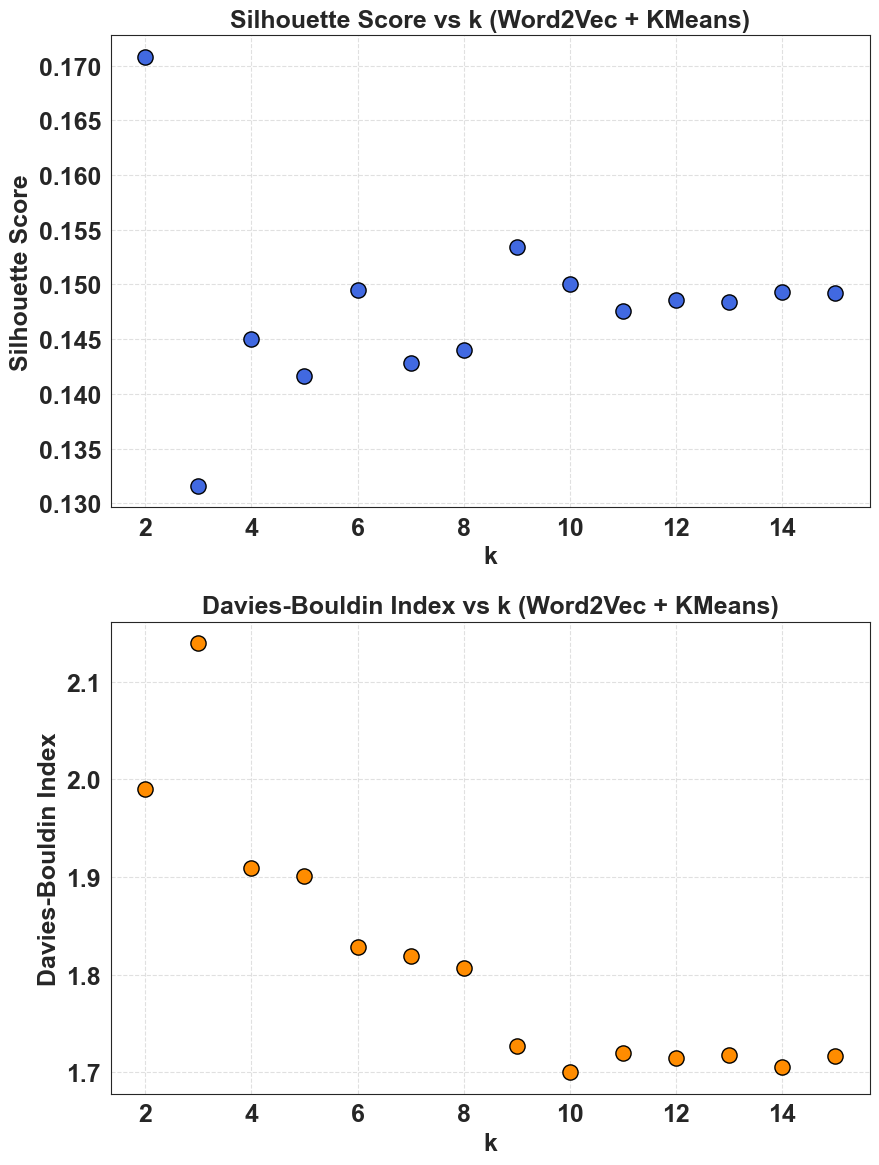

In [296]:
import matplotlib.pyplot as plt

# Set global font size and bold weight
plt.rcParams.update({'font.size': 18, 'font.weight': 'bold'})

# Create figure with 2 rows and 1 column
plt.figure(figsize=(9, 12))

# Plot 1: Silhouette Score (Scatter)
plt.subplot(2, 1, 1)
plt.scatter(avg_metrics_df["k"], avg_metrics_df["Silhouette Score"], s=120, color='royalblue', edgecolor='black')
plt.title("Silhouette Score vs k (Word2Vec + KMeans)", fontsize=18, fontweight='bold')
plt.xlabel("k", fontsize=18, fontweight='bold')
plt.ylabel("Silhouette Score", fontsize=18, fontweight='bold')
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 2: Davies-Bouldin Index (Scatter)
plt.subplot(2, 1, 2)
plt.scatter(avg_metrics_df["k"], avg_metrics_df["Davies-Bouldin Index"], s=120, color='darkorange', edgecolor='black')
plt.title("Davies-Bouldin Index vs k (Word2Vec + KMeans)", fontsize=18, fontweight='bold')
plt.xlabel("k", fontsize=18, fontweight='bold')
plt.ylabel("Davies-Bouldin Index", fontsize=18, fontweight='bold')
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [119]:
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display

# Create a copy to avoid modifying the original
score_df = avg_metrics_df.copy()

# ✅ Normalize the correct columns
scaler = MinMaxScaler()
score_df[["Silhouette_Norm", "DBI_Norm"]] = scaler.fit_transform(
    score_df[["Silhouette Score", "Davies-Bouldin Index"]]
)

# ✅ Invert DBI (lower is better)
score_df["DBI_Norm_Inverted"] = 1 - score_df["DBI_Norm"]

# ✅ Final Combined Score
score_df["Combined_Score"] = score_df["Silhouette_Norm"] + score_df["DBI_Norm_Inverted"]

# ✅ Sort by combined score
score_df_sorted = score_df.sort_values(by="Combined_Score", ascending=False).reset_index(drop=True)

# ✅ Display comparison
display(score_df_sorted[["k", "Silhouette Score", "Davies-Bouldin Index", "Combined_Score"]])

# ✅ Select best k
best_k = int(score_df_sorted.iloc[0]["k"])
print(f"✅ Best k selected based on Silhouette↑ and DBI↓: {best_k}")


k  Silhouette Score  Davies-Bouldin Index  Combined_Score
0    9            0.1534                1.7272    1.494234e+00
1   10            0.1500                1.7000    1.469388e+00
2   14            0.1493                1.7052    1.439699e+00
3   15            0.1492                1.7170    1.410299e+00
4   12            0.1486                1.7146    1.400454e+00
5   13            0.1484                1.7181    1.387388e+00
6   11            0.1476                1.7197    1.363340e+00
7    2            0.1708                1.9900    1.340159e+00
8    6            0.1495                1.8287    1.163800e+00
9    8            0.1440                1.8070    1.072868e+00
10   7            0.1428                1.8188    1.015407e+00
11   4            0.1450                1.9090    8.662963e-01
12   5            0.1416                1.9014    7.968540e-01
13   3            0.1316                2.1395    4.440892e-16

✅ Best k selected based on Silhouette↑ and DBI↓: 9


###  Final Clustering (Word2Vec + KMeans, best k)  
- Run **KMeans** with the selected best k.  
- Auto-generate cluster labels from top keywords.  
- Visualize clusters using **PCA, t-SNE, and UMAP** for interpretability.  
r.


📌 Final Cluster Labels with Top Keywords:

Cluster 0 → Label: 'event_student'
   Top Keywords: ['event', 'student', 'campus', 'share', 'community', 'news', 'home', 'center', 'college', 'post']

Cluster 1 → Label: 'program_college'
   Top Keywords: ['program', 'college', 'student', 'education', 'news', 'school', 'good', 'online', 'degree', 'pharmacy']

Cluster 2 → Label: 'year_president'
   Top Keywords: ['student', 'college', 'year', 'president', 'serve', 'business', 'award', 'board', 'program', 'professor']

Cluster 3 → Label: 'work_home'
   Top Keywords: ['student', 'year', 'work', 'home', 'take', 'horse', 'time', 'share', 'program', 'people']

Cluster 4 → Label: 'art_perform'
   Top Keywords: ['art', 'perform', 'concert', 'broadway', 'student', 'event', 'ticket', 'music', 'fine', 'release']

Cluster 5 → Label: 'campus_community'
   Top Keywords: ['student', 'program', 'college', 'campus', 'community', 'health', 'news', 'work', 'school', 'share']

Cluster 6 → Label: 'food_help'
   To

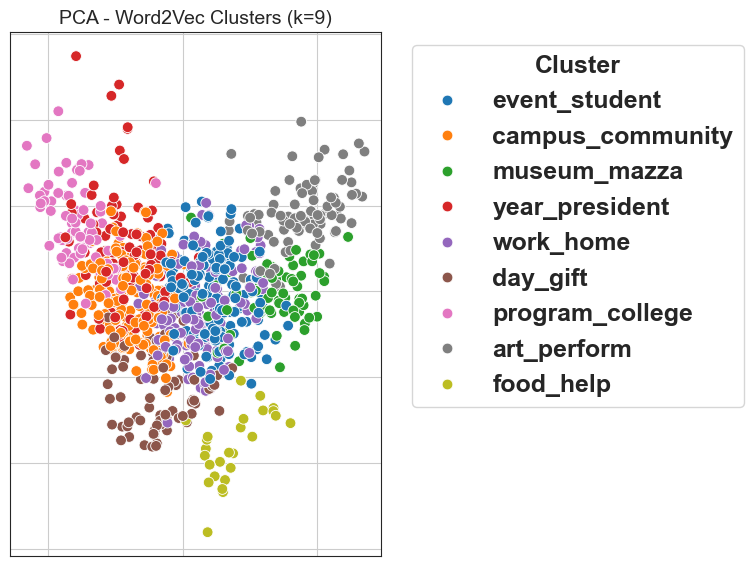

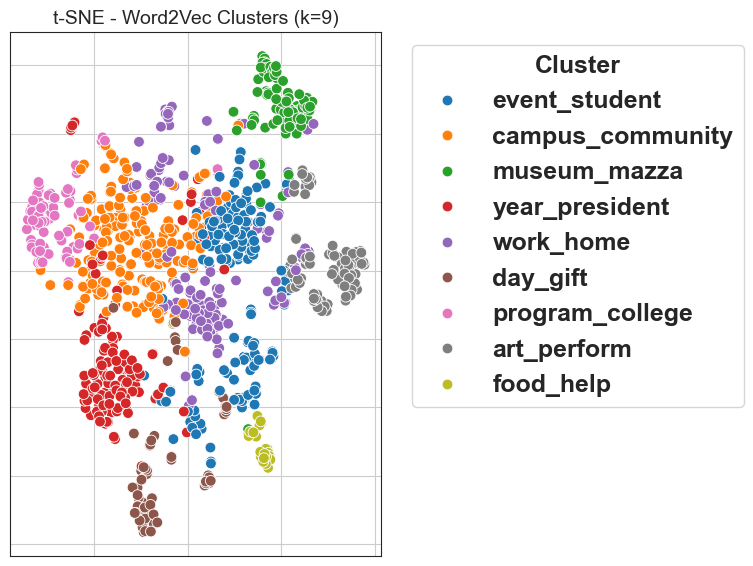

C:\Users\ROHITH\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


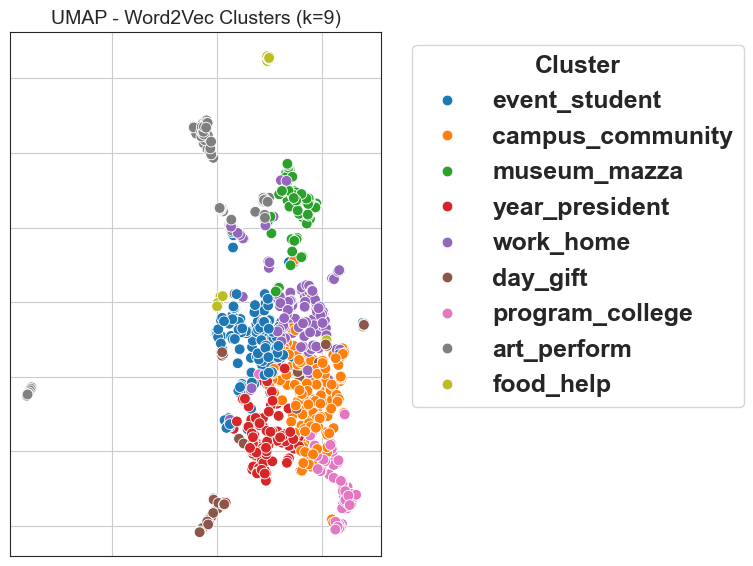

In [256]:

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# ✅ Final KMeans clustering with best k
final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df["FinalCluster"] = final_kmeans.fit_predict(doc_vectors)

# 🧠 Get top keywords from tokens per cluster
def get_top_keywords(token_lists, top_n=20):
    all_words = [word for tokens in token_lists for word in tokens]
    most_common = Counter(all_words).most_common(top_n)
    return [word for word, _ in most_common]

# 🔖 Pick best label (prefer multi-word phrases for clarity)
def pick_label(keywords, used_labels, used_tokens):
    ignore = {
        "university", "findlay", "uf", "students", "said", "views",
        "shares", "facebook", "tweet", "new", "best", "show"
    }

    # Try bigram, then trigram, then unigram
    # (skip phrases containing only ignored words)
    for n in [2, 3, 1]:  
        if len(keywords) >= n:
            for i in range(len(keywords) - n + 1):
                candidate = "_".join(keywords[i:i+n])
                candidate_tokens = set(candidate.split("_"))
                if (
                    candidate.lower() not in ignore
                    and candidate not in used_labels
                    and candidate_tokens.isdisjoint(used_tokens)
                ):
                    return candidate, candidate_tokens

    # Fallback: generic theme
    fallback = f"theme_{len(used_labels)}"
    return fallback, {fallback}

# 🔖 Generate cluster labels
cluster_labels = {}
used_labels = set()
used_tokens = set()

print("📌 Final Cluster Labels with Top Keywords:\n")
for cluster_id in sorted(df["FinalCluster"].unique()):
    token_lists = df[df["FinalCluster"] == cluster_id]["Cleaned_Tokens"]
    top_words = get_top_keywords(token_lists, top_n=20)
    label, label_tokens = pick_label(top_words, used_labels, used_tokens)

    cluster_labels[cluster_id] = label
    used_labels.add(label)
    used_tokens.update(label_tokens)

    # Print results for review
    print(f"Cluster {cluster_id} → Label: '{label}'")
    print(f"   Top Keywords: {top_words[:10]}")
    print()

# Add labels to DataFrame
df["Cluster_Label"] = df["FinalCluster"].map(cluster_labels)

# 🔍 Visualization function using labels
def plot_2D(data_2d, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=data_2d[:, 0],
        y=data_2d[:, 1],
        hue=labels,
        palette="tab10",
        s=60
    )
    plt.title(title, fontsize=14)
    plt.xlabel("")   # remove axis label
    plt.ylabel("")   # remove axis label
    plt.grid(True)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 🔢 Dimensionality reduction & plotting
X_pca = PCA(n_components=2, random_state=42).fit_transform(doc_vectors)
plot_2D(X_pca, df["Cluster_Label"], f"PCA - Word2Vec Clusters (k={best_k})")

X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(doc_vectors)
plot_2D(X_tsne, df["Cluster_Label"], f"t-SNE - Word2Vec Clusters (k={best_k})")

X_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(doc_vectors)
plot_2D(X_umap, df["Cluster_Label"], f"UMAP - Word2Vec Clusters (k={best_k})")


In [262]:
# ===============================================
# 🎯 Manual cluster name mapping for presentation
# ===============================================
from collections import Counter

# 🏷️ Manual cluster theme mapping
custom_cluster_name_map = {
    0: "Campus Events & Student Activities",          # from 'event_student'
    1: "Arts & Performing Highlights",                # from 'art_perform'
    2: "Education & Academic Achievements",           # from 'college_year'
    3: "Mazza Museum & Art Features",                 # from 'museum_mazza'
    4: "Work-Life Balance & Homefront",               # from 'work_home'
    5: "Education Programs & University News",        # from 'education_news'
    6: "Food Drives & Student Support",               # from 'food_help'
    7: "Giving Day & Campus Donations",               # from 'give_campus'
    8: "Community Outreach in Ohio",                  # from 'provide_ohio'
}

# ✅ Replace old labels with cleaner mapped labels
df["Cluster_Label_Manual"] = df["FinalCluster"].map(custom_cluster_name_map)

# 📌 Print top keywords for each manually named cluster
print("📌 Manual Cluster Labels with Top Keywords:\n")
for cluster_id, label_name in custom_cluster_name_map.items():
    token_lists = df[df["FinalCluster"] == cluster_id]["Cleaned_Tokens"]
    all_words = [word for tokens in token_lists for word in tokens]
    top_keywords = [word for word, _ in Counter(all_words).most_common(10)]
    print(f"{cluster_id}: {label_name}")
    print(f"   Top Keywords: {', '.join(top_keywords)}\n")


📌 Manual Cluster Labels with Top Keywords:

0: Campus Events & Student Activities
   Top Keywords: event, student, campus, share, community, news, home, center, college, post

1: Arts & Performing Highlights
   Top Keywords: program, college, student, education, news, school, good, online, degree, pharmacy

2: Education & Academic Achievements
   Top Keywords: student, college, year, president, serve, business, award, board, program, professor

3: Mazza Museum & Art Features
   Top Keywords: student, year, work, home, take, horse, time, share, program, people

4: Work-Life Balance & Homefront
   Top Keywords: art, perform, concert, broadway, student, event, ticket, music, fine, release

5: Education Programs & University News
   Top Keywords: student, program, college, campus, community, health, news, work, school, share

6: Food Drives & Student Support
   Top Keywords: food, help, pound, year, drive, hand, student, event, collect, campus

7: Giving Day & Campus Donations
   Top Keywo

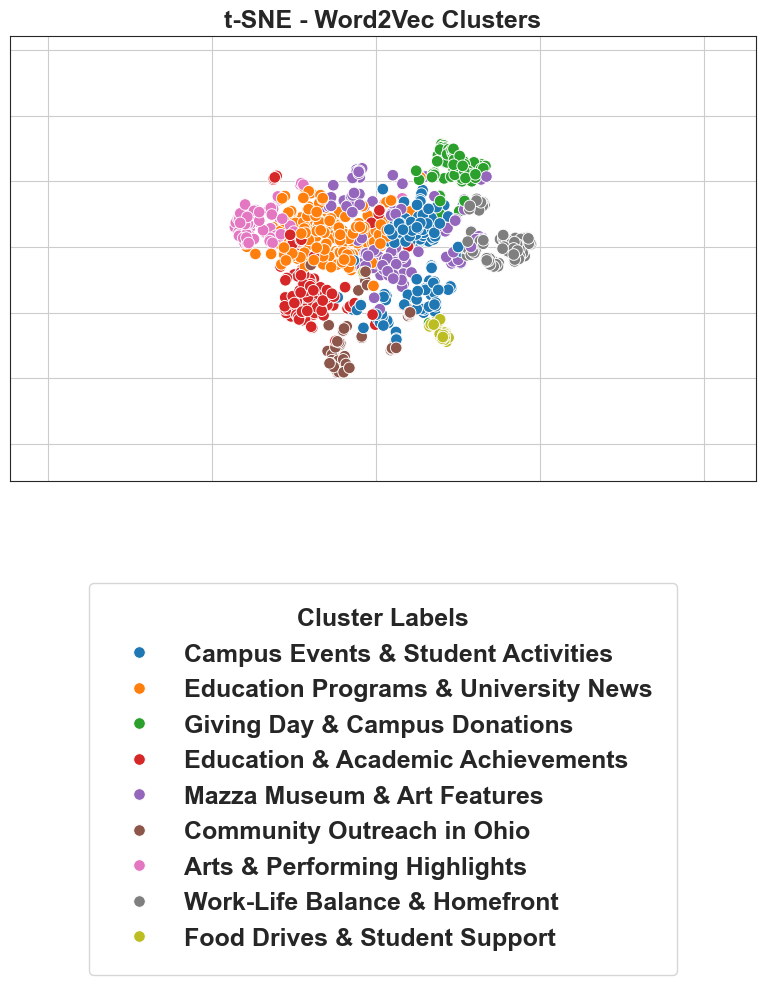

In [276]:
# ===============================================
# 🎨 Final Plot: t-SNE with Manual Labels (1:1 ratio, left-aligned legend)
# ===============================================
import matplotlib.pyplot as plt
import seaborn as sns

def plot_2D(data_2d, labels, title):
    plt.figure(figsize=(8, 11))  # Square canvas

    # ✏️ Scatterplot
    sns.scatterplot(
        x=data_2d[:, 0],
        y=data_2d[:, 1],
        hue=labels,
        palette="tab10",
        s=70
    )

    # ✏️ Title and axis styling
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel("", fontsize=18, fontweight='bold')
    plt.ylabel("", fontsize=18, fontweight='bold')
    plt.grid(True)
    plt.axis("equal")  # 1:1 ratio

    # ✏️ Remove tick labels
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])

    # ✏️ Legend below with left alignment and bold, single-line labels
    legend = plt.legend(
        title="Cluster Labels",
        loc='upper center',
        bbox_to_anchor=(0.5, -0.2),  # Further below
        ncol=1,                      # One label per line
        frameon=True,
        fontsize=18,
        title_fontsize=18,
        borderpad=1
    )

    # 🔠 Bold and left-align legend text
    for text in legend.get_texts():
        text.set_fontweight('bold')
        text.set_ha('left')  # Left alignment
    legend.get_title().set_fontweight('bold')

    plt.tight_layout()
    plt.show()

# 🔢 Run plot
plot_2D(X_tsne, df["Cluster_Label_Manual"], "t-SNE - Word2Vec Clusters")


In [141]:
custom_cluster_name_map = {
    0: "Campus Events & Student Activities",
    1: "Arts & Performing Highlights",
    2: "Education & Academic Achievements",
    3: "Mazza Museum & Art Features",
    4: "Work-Life Balance & Homefront",
    5: "Education Programs & University News",
    6: "Food Drives & Student Support",
    7: "Giving Day & Campus Donations",
    8: "Community Outreach in Ohio",
}


In [143]:
df["ManualClusterLabel"] = df["FinalCluster"].map(custom_cluster_name_map)


###  Save Final Scores (Word2Vec + KMeans)  
- Record the selected **best k** with its Silhouette Score and Davies-Bouldin Index.  
- Append results to the master file (`model_scores_word2vec_kmeans.csv`).  
- Maintain consistency for comparison across all models.  
.


In [130]:
import pandas as pd

# ✅ Create empty DataFrame with header columns
header_row = pd.DataFrame(columns=[
    "Embedding", "Clustering", "Best_k", "Silhouette_Score", "Davies_Bouldin_Index"
])

# ✅ Save it to file (will overwrite if already exists)
header_row.to_csv("model_scores_word2vec_kmeans.csv", index=False)

print("✅ Header row created in 'model_scores_word2vec_kmeans.csv'")


✅ Header row created in 'model_scores_word2vec_kmeans.csv'


In [132]:
import pandas as pd

# ✅ Load saved evaluation metrics
metrics_df = pd.read_csv("word2vec_kmeans_evaluation.csv")
metrics_df_sorted = metrics_df.sort_values("k").reset_index(drop=True)

# ✅ Extract the best_k value (make sure this is already computed earlier)
# If not already available, load it from earlier calculation
# best_k = 7  # Uncomment if you know the best_k manually

# ✅ Extract scores
sil_score = round(metrics_df_sorted.loc[metrics_df_sorted["k"] == best_k, "Silhouette Score"].values[0], 4)
db_score = round(metrics_df_sorted.loc[metrics_df_sorted["k"] == best_k, "Davies-Bouldin Index"].values[0], 4)

# ✅ Create the row
final_score_row = pd.DataFrame([{
    "Embedding": "Word2Vec",
    "Clustering": "KMeans",
    "Best_k": best_k,
    "Silhouette_Score": sil_score,
    "Davies_Bouldin_Index": db_score
}])

# ✅ Save to file (append without header)
final_score_row.to_csv("model_scores_word2vec_kmeans.csv", mode="a", index=False, header=False)

print("✅ Word2Vec + KMeans final scores saved to 'model_scores_word2vec_kmeans.csv'")


✅ Word2Vec + KMeans final scores saved to 'model_scores_word2vec_kmeans.csv'


In [134]:
# ✅ Save clustering results with Views for later analysis
df.to_csv("uf_newsroom_word2vec_kmeans.csv", index=False, encoding="utf-8")
print("✅ Saved Word2Vec + KMeans clustered dataset to 'uf_newsroom_word2vec_kmeans.csv'")


✅ Saved Word2Vec + KMeans clustered dataset to 'uf_newsroom_word2vec_kmeans.csv'


In [136]:
df = pd.read_csv("uf_newsroom_word2vec_kmeans.csv")
print(df.columns.tolist())


['Title', 'Link', 'Date', 'Views', 'Content', 'Cleaned_Tokens', 'Cleaned_Text', 'FinalCluster', 'Cluster_Label', 'Cluster_Label_Manual']


###  Audience Insights by View Count  
- Group articles by **cluster labels**.  
- Calculate **average & total views** per cluster.  
- Plot **bar chart** (average views) and **pie chart** (view share).  
- Identify clusters with **highest audience interest**.  


🔝 Most Viewed Article:
Title        : University of Findlay Moving to Remote Classes in Proactive Response to COVID-19
Views        : 9000
Cluster ID   : 5
Cluster Label: Education Programs
& University News
Date         : Posted On March 10, 2020

📊 Views by Cluster:
                                          sum        mean  count
ManualClusterLabel                                              
Education Programs\n& University News  104696  520.875622    201
Mazza Museum &\nArt Features            82628  565.945205    146
Education & Academic\nAchievements      71279  584.254098    122
Campus Events\n& Student Activities     67021  389.656977    172
Arts & Performing\nHighlights           50370  614.268293     82
Giving Day &\nCampus Donations          29180  335.402299     87
Work-Life Balance\n& Homefront          28245  310.384615     91
Community Outreach\nin Ohio             25455  348.698630     73
Food Drives &\nStudent Support           7218  277.615385     26


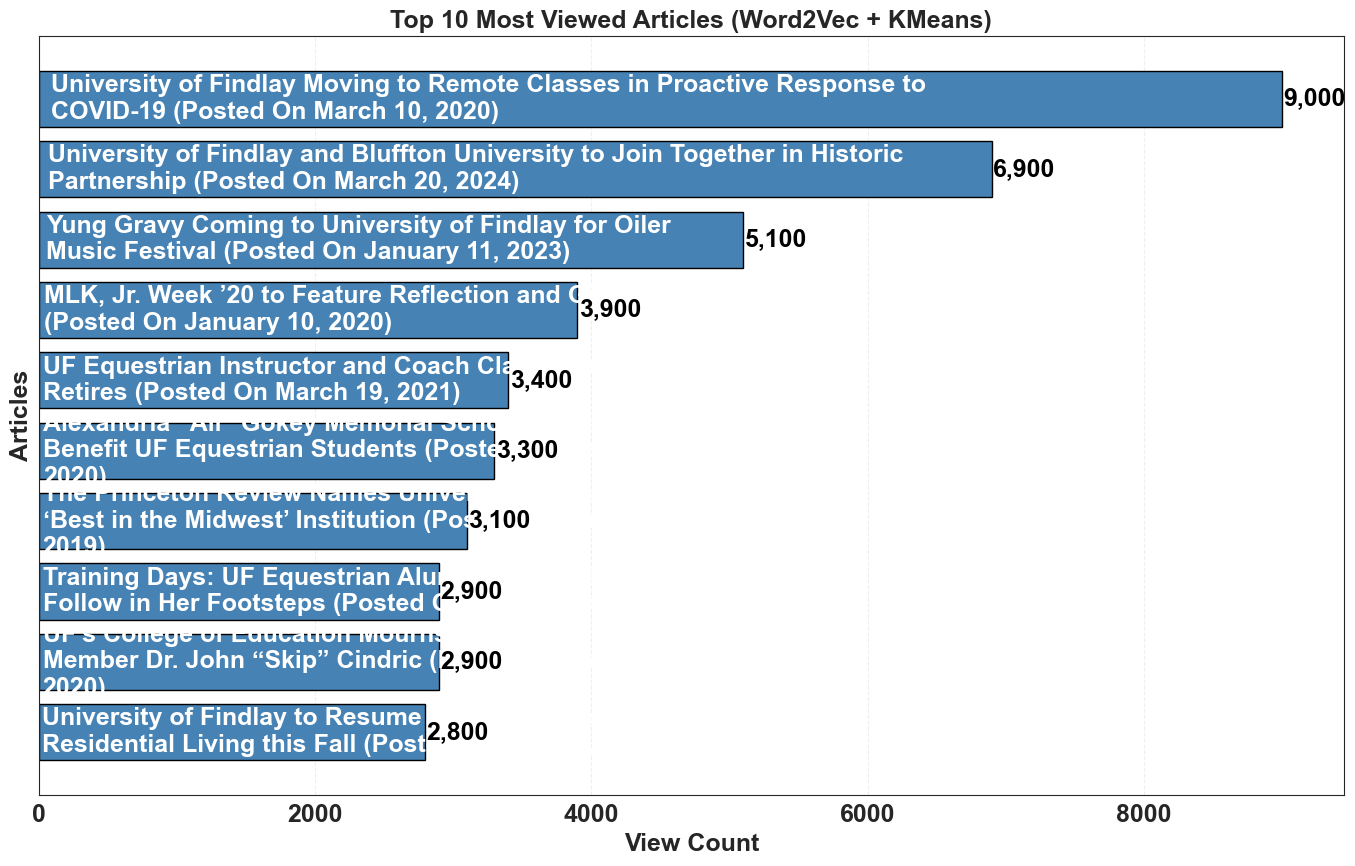

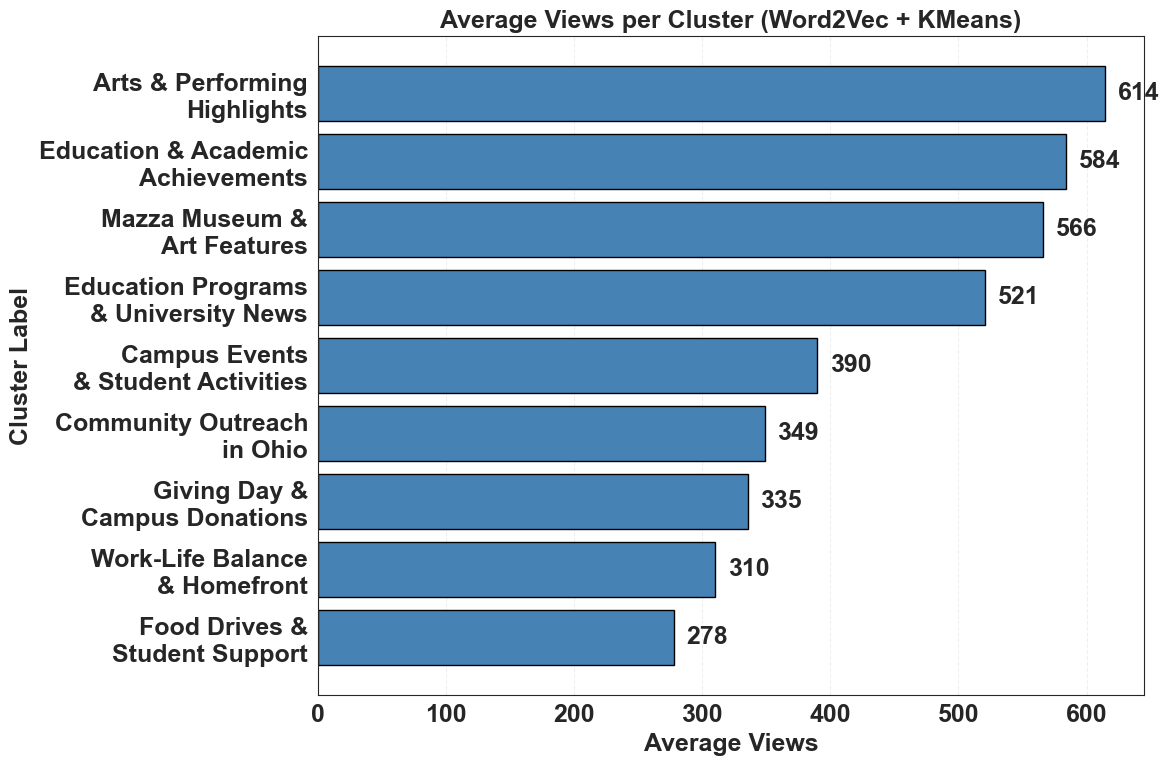


🔑 Top 10 Keywords for Each Cluster:

Cluster 'Arts & Performing
Highlights' → ['program', 'college', 'student', 'education', 'news', 'school', 'good', 'online', 'degree', 'pharmacy']
Cluster 'Campus Events
& Student Activities' → ['event', 'student', 'campus', 'share', 'community', 'news', 'home', 'center', 'college', 'post']
Cluster 'Community Outreach
in Ohio' → ['student', 'give', 'campus', 'day', 'gift', 'community', 'year', 'event', 'support', 'donor']
Cluster 'Education & Academic
Achievements' → ['student', 'college', 'year', 'president', 'serve', 'business', 'award', 'board', 'program', 'professor']
Cluster 'Education Programs
& University News' → ['student', 'program', 'college', 'campus', 'community', 'health', 'news', 'work', 'school', 'share']
Cluster 'Food Drives &
Student Support' → ['food', 'help', 'pound', 'year', 'drive', 'hand', 'student', 'event', 'collect', 'campus']
Cluster 'Giving Day &
Campus Donations' → ['museum', 'mazza', 'book', 'art', 'artist', 'event', 'fe

In [284]:
import pandas as pd
import matplotlib.pyplot as plt
import textwrap
from collections import Counter
import ast

# ✅ Load enriched dataset
df = pd.read_csv("uf_newsroom_word2vec_kmeans.csv")

# ✅ Manual cluster name mapping (2 lines each)
custom_cluster_name_map = {
    0: "Campus Events\n& Student Activities",
    1: "Arts & Performing\nHighlights",
    2: "Education & Academic\nAchievements",
    3: "Mazza Museum &\nArt Features",
    4: "Work-Life Balance\n& Homefront",
    5: "Education Programs\n& University News",
    6: "Food Drives &\nStudent Support",
    7: "Giving Day &\nCampus Donations",
    8: "Community Outreach\nin Ohio",
}

# ✅ Map manual labels
df["ManualClusterLabel"] = df["FinalCluster"].map(custom_cluster_name_map)

# ✅ Helper to clean Views column
def parse_views(val):
    if pd.isna(val):
        return 0
    val = str(val).replace("\xa0", " ").replace("Views", "").replace(",", "").strip()
    if "not found" in val.lower():
        return 0
    if val.endswith("K"):
        return int(float(val[:-1]) * 1000)
    if val.endswith("M"):
        return int(float(val[:-1]) * 1_000_000)
    try:
        return int(val)
    except:
        return 0

df["Views"] = df["Views"].apply(parse_views)

# 🔝 Most viewed article
max_view_article = df.loc[df["Views"].idxmax()]
print("🔝 Most Viewed Article:")
print(f"Title        : {max_view_article['Title']}")
print(f"Views        : {max_view_article['Views']}")
print(f"Cluster ID   : {max_view_article['FinalCluster']}")
print(f"Cluster Label: {max_view_article['ManualClusterLabel']}")
print(f"Date         : {max_view_article['Date']}")

# 📊 Cluster stats
cluster_views = (
    df.groupby("ManualClusterLabel")["Views"]
    .agg(["sum", "mean", "count"])
    .sort_values("sum", ascending=False)
)

print("\n📊 Views by Cluster:")
print(cluster_views)

# ======================================
# 📈 PLOT 1: Top 10 Most Viewed Articles
# ======================================
top10_articles = df.sort_values("Views", ascending=False).head(10)

plt.figure(figsize=(14, 9))
bars = plt.barh(range(len(top10_articles)), top10_articles["Views"],
                color="steelblue", edgecolor="black")

for i, (bar, row) in enumerate(zip(bars, top10_articles.itertuples())):
    clean_date = str(row.Date).replace("Posted on", "").strip()
    full_title = f"{row.Title} ({clean_date})"

    # ✅ Strict wrapping logic
    if i < 2:
        shortened = textwrap.shorten(full_title, width=90, placeholder="...")
        wrapped = "\n".join(textwrap.wrap(full_title, width=75))
        font_size = 18
    elif i < 5:
        wrapped = "\n".join(textwrap.wrap(full_title, width=55))
        font_size = 18
    else:
        wrapped = "\n".join(textwrap.wrap(full_title, width=55))
        font_size = 18

    # 📝 Add title text to bars
    plt.text(
        bar.get_width() * 0.01,
        bar.get_y() + bar.get_height() / 2,
        wrapped,
        va="center", ha="left", color="white",
        fontsize=font_size, fontweight="bold"
    )

    # 🔢 View count
    plt.text(
        bar.get_width() + 10,
        bar.get_y() + bar.get_height() / 2,
        f"{row.Views:,}",
        va="center", ha="left", color="black",
        fontsize=18, fontweight="bold"
    )

plt.title("Top 10 Most Viewed Articles (Word2Vec + KMeans)", fontsize=18, fontweight="bold")
plt.xlabel("View Count", fontsize=18, fontweight="bold")
plt.ylabel("Articles", fontsize=18, fontweight="bold")
plt.xticks(fontsize=18, fontweight="bold")
plt.yticks([])
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# ============================================
# 📈 PLOT 2: Average Views per Manual Cluster
# ============================================
avg_cluster_views = cluster_views["mean"].sort_values(ascending=False)

plt.figure(figsize=(12, 8))
bars = plt.barh(avg_cluster_views.index, avg_cluster_views.values,
                color="steelblue", edgecolor="black")

for bar, value in zip(bars, avg_cluster_views.values):
    plt.text(
        bar.get_width() + 10,
        bar.get_y() + bar.get_height() / 2,
        f"{value:,.0f}",
        va="center", ha="left",
        fontsize=18, fontweight="bold"
    )

plt.title("Average Views per Cluster (Word2Vec + KMeans)", fontsize=18, fontweight="bold")
plt.xlabel("Average Views", fontsize=18, fontweight="bold")
plt.ylabel("Cluster Label", fontsize=18, fontweight="bold")
plt.xticks(fontsize=18, fontweight="bold")
plt.yticks(fontsize=18, fontweight="bold")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 🔑 Top 10 Keywords Per Cluster
print("\n🔑 Top 10 Keywords for Each Cluster:\n")
for cluster_id, group in df.groupby("ManualClusterLabel"):
    tokens = group["Cleaned_Tokens"].apply(ast.literal_eval).tolist()
    all_words = [word for tokens_list in tokens for word in tokens_list]
    top_words = [w for w, _ in Counter(all_words).most_common(10)]
    print(f"Cluster '{cluster_id}' → {top_words}")


C:\Users\ROHITH\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128216 (\N{BLUE BOOK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


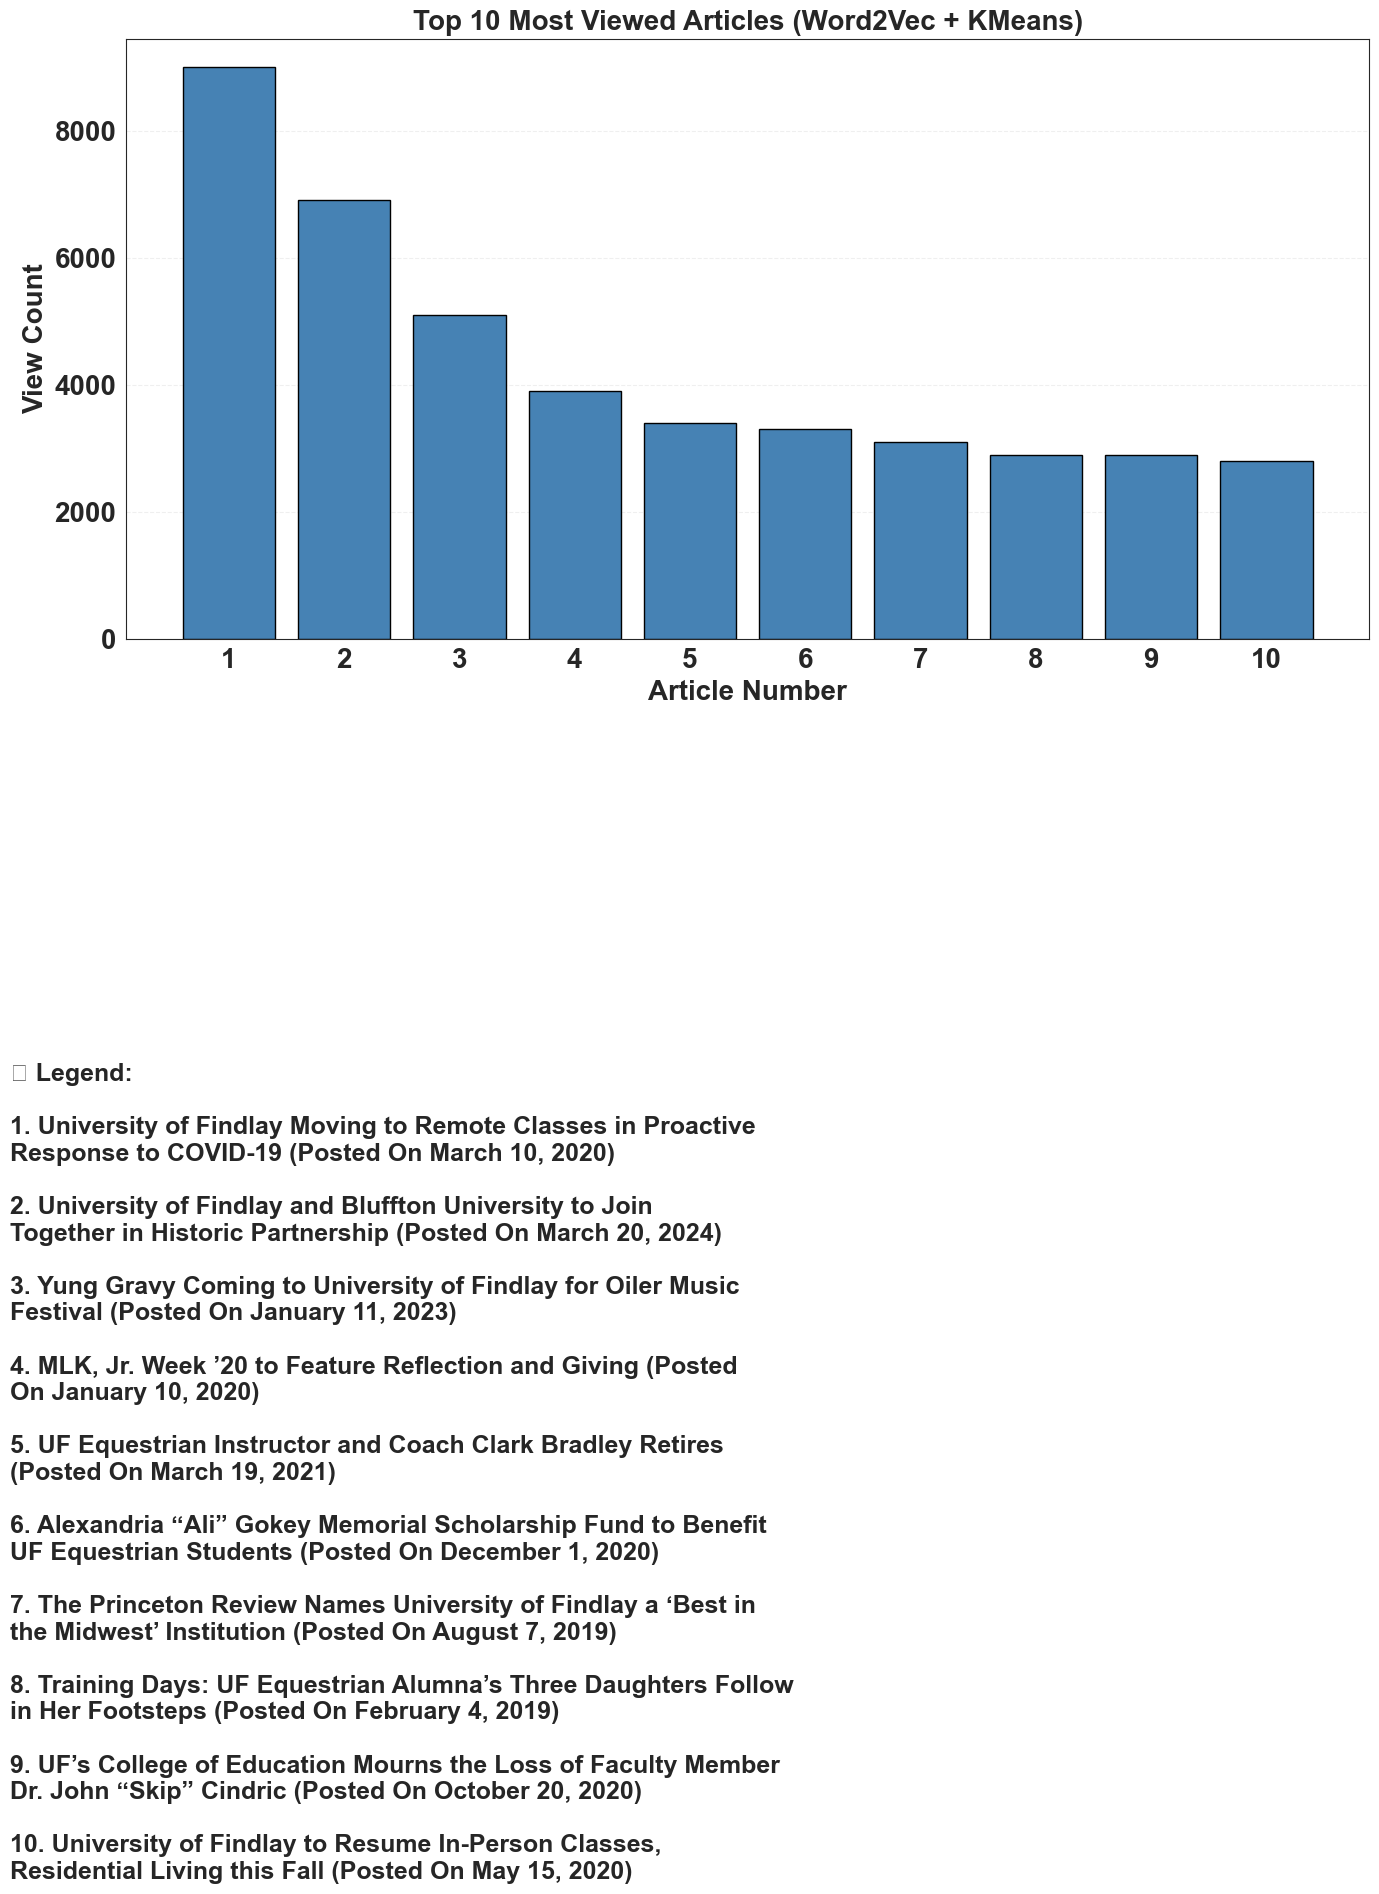

In [298]:
import matplotlib.pyplot as plt
import textwrap

# 🔟 Top 10 Most Viewed Articles
top10_articles = df.sort_values("Views", ascending=False).head(10).reset_index()

# 📌 Generate numeric labels and wrapped legend titles
article_numbers = list(range(1, 11))
article_titles = []

for row in top10_articles.itertuples():
    clean_date = str(row.Date).replace("Posted on", "").strip()
    full_title = f"{row.Title} ({clean_date})"
    wrapped_title = "\n".join(textwrap.wrap(full_title, width=60))  # Wrap to 2 lines
    article_titles.append(wrapped_title)

# 📊 Create clean vertical histogram (bars only)
plt.figure(figsize=(14, 10))
bars = plt.bar(article_numbers, top10_articles["Views"],
               color="steelblue", edgecolor="black")

# ❌ Removed numeric view labels above bars

# 🏷️ Axis formatting
plt.title("Top 10 Most Viewed Articles (Word2Vec + KMeans)", fontsize=20, fontweight="bold")
plt.xlabel("Article Number", fontsize=20, fontweight="bold")
plt.ylabel("View Count", fontsize=20, fontweight="bold")
plt.xticks(article_numbers, [str(i) for i in article_numbers], fontsize=20, fontweight="bold")
plt.yticks(fontsize=20, fontweight="bold")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout(rect=[0, 0.25, 1, 1])  # Space for legend

# 📘 Legend below plot
legend_lines = [
    f"{i}. {title}" for i, title in zip(article_numbers, article_titles)
]
legend_text = "\n\n".join(legend_lines)

plt.figtext(0.01, -0.08, f"📘 Legend:\n\n{legend_text}", fontsize=18, fontweight="bold", ha="left", va="top")

plt.show()


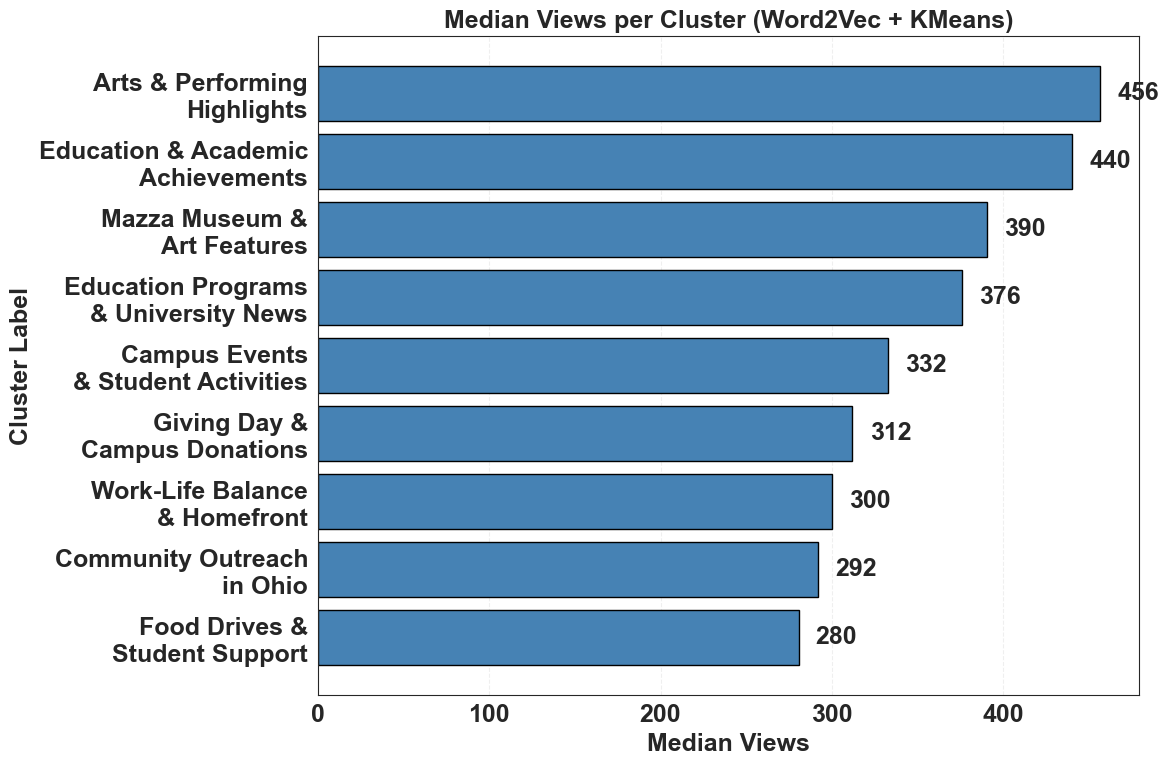

In [300]:
# ============================================
# 📈 PLOT 3: Median Views per Manual Cluster
# ============================================
median_cluster_views = (
    df.groupby("ManualClusterLabel")["Views"]
    .median()
    .sort_values(ascending=False)
)

plt.figure(figsize=(12, 8))
bars = plt.barh(median_cluster_views.index, median_cluster_views.values,
                color="steelblue", edgecolor="black")

for bar, value in zip(bars, median_cluster_views.values):
    plt.text(
        bar.get_width() + 10,
        bar.get_y() + bar.get_height() / 2,
        f"{value:,.0f}",
        va="center", ha="left",
        fontsize=18, fontweight="bold"
    )

plt.title("Median Views per Cluster (Word2Vec + KMeans)", fontsize=18, fontweight="bold")
plt.xlabel("Median Views", fontsize=18, fontweight="bold")
plt.ylabel("Cluster Label", fontsize=18, fontweight="bold")
plt.xticks(fontsize=18, fontweight="bold")
plt.yticks(fontsize=18, fontweight="bold")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


###  Data Collection (GloVe + KMeans)  
- Load the cleaned dataset of **1000 Findlay Newsroom articles**.  
- Use Pandas to read the CSV file into a DataFrame.  
- Confirm the number of articles and preview the first rows.  

ng


In [77]:

import pandas as pd

# Load the cleaned dataset
cleaned_file_path = "uf_newsroom_1000_articles_cleaned.csv"
df = pd.read_csv(cleaned_file_path)

print(f"✅ Loaded cleaned dataset with {df.shape[0]} articles.")
df.head(2)


✅ Loaded cleaned dataset with 1000 articles.


Title  \
0  Blanchard Valley Health System CEO to speak Oc...   
1  UF Alumni, Friends, Community Invited to ‘Come...   

                                                Link  \
0  https://newsroom.findlay.edu/blanchard-valley-...   
1  https://newsroom.findlay.edu/uf-alumni-friends...   

                           Date  Views  \
0  Posted On September 18, 2025    158   
1  Posted On September 11, 2025     89   

                                             Content  \
0  Home » Campus College of Health Professions Co...   
1  Home » Campus Community Events Featured News R...   

                                      Cleaned_Tokens  \
0  ['home', 'campus', 'college', 'health', 'profe...   
1  ['home', 'campus', 'community', 'event', 'feat...   

                                        Cleaned_Text  
0  home campus college health profession communit...  
1  home campus community event feature news relea...

###  Embedding +  Clustering (GloVe + KMeans)  
- Load the pretrained **GloVe embeddings** (100d, word2vec format).  
- Convert each article into a document vector by averaging its token embeddings.  
- Apply **KMeans clustering** for k = 2 to 15, repeating each setting 20 times.  
- Record **Silhouette Score** (higher = better) and **Davies-Bouldin Index** (lower = better).  
- Save all results to `glove_kmeans_20runs.csv` for later analysis.  
`.  
s.  
nce


In [82]:
# 🔁 Step 2: GloVe + KMeans Clustering (20 runs per k = 2 to 15)
from gensim.models import KeyedVectors
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tqdm import tqdm
import random

# Load GloVe model (word2vec format)
glove_model_path = "glove.6B.100d.word2vec.txt"
glove_model = KeyedVectors.load_word2vec_format(glove_model_path, binary=False)

# Convert tokens to document vectors using GloVe
def get_glove_vector(tokens, model, vector_size=100):
    vectors = [model[word] for word in tokens if word in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

# Ensure tokens are lists (not strings)
token_lists = df["Cleaned_Tokens"].apply(eval).tolist()

# Create document vectors
glove_vectors = np.array([get_glove_vector(tokens, glove_model) for tokens in token_lists])

# Run KMeans 20x for each k
results = []
print("🔁 Running KMeans 20 times for each k (2 to 15)...\n")
for k in tqdm(range(2, 16), desc="Evaluating k"):
    for run in range(20):
        kmeans = KMeans(n_clusters=k, random_state=run, n_init=10)
        labels = kmeans.fit_predict(glove_vectors)

        sil = silhouette_score(glove_vectors, labels)
        dbi = davies_bouldin_score(glove_vectors, labels)

        results.append({
            "k": k,
            "Run": run + 1,
            "Silhouette Score": round(sil, 4),
            "Davies-Bouldin Index": round(dbi, 4)
        })

# Save results
results_df = pd.DataFrame(results)
results_df.to_csv("glove_kmeans_20runs.csv", index=False)
print("✅ Saved GloVe + KMeans 20-run scores to 'glove_kmeans_20runs.csv'")


🔁 Running KMeans 20 times for each k (2 to 15)...



Evaluating k: 100%|██████████| 14/14 [00:51<00:00,  3.66s/it]

✅ Saved GloVe + KMeans 20-run scores to 'glove_kmeans_20runs.csv'


###  Evaluation (GloVe + KMeans)  
- Load the **20-run clustering results** from CSV.  
- Compute average **Silhouette Score** and **Davies-Bouldin Index** for each k.  
- Display results in a comparison table.  
- Plot **Silhouette Score vs k** (higher = better).  
- Plot **Davies-Bouldin Index vs k** (lower = better).  
).  


In [85]:
# ✅ Step 3: Analyze GloVe + KMeans Scores
import pandas as pd
import matplotlib.pyplot as plt

# Load 20-run evaluation results
glove_kmeans_scores_df = pd.read_csv("glove_kmeans_20runs.csv")

# Compute average Silhouette and DBI per k
glove_averages_df = glove_kmeans_scores_df.groupby("k").agg({
    "Silhouette Score": "mean",
    "Davies-Bouldin Index": "mean"
}).reset_index()

# Round for clarity
glove_averages_df["Silhouette Score"] = glove_averages_df["Silhouette Score"].round(4)
glove_averages_df["Davies-Bouldin Index"] = glove_averages_df["Davies-Bouldin Index"].round(4)

# Display the comparison table
from IPython.display import display
display(glove_averages_df)



k  Silhouette Score  Davies-Bouldin Index
0    2            0.1417                2.2936
1    3            0.1131                2.4627
2    4            0.1042                2.3865
3    5            0.0969                2.4117
4    6            0.0909                2.4296
5    7            0.0903                2.4858
6    8            0.0869                2.4767
7    9            0.0881                2.3906
8   10            0.0892                2.3443
9   11            0.0876                2.3227
10  12            0.0875                2.3171
11  13            0.0886                2.2862
12  14            0.0887                2.2658
13  15            0.0886                2.2813

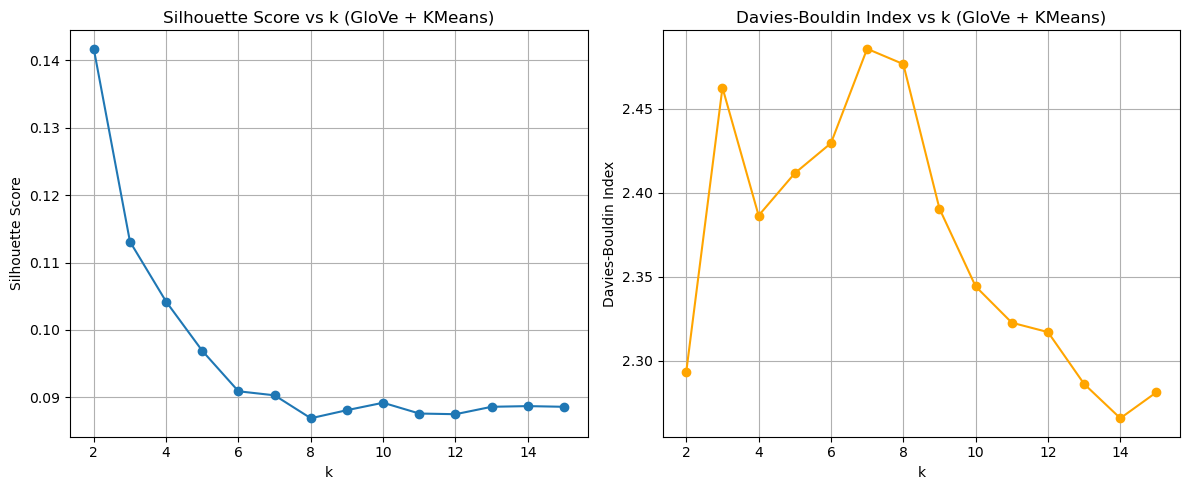

In [87]:
import matplotlib.pyplot as plt

# Plot Silhouette Score
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(glove_averages_df["k"], glove_averages_df["Silhouette Score"], marker='o')
plt.title("Silhouette Score vs k (GloVe + KMeans)")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)

# Plot Davies-Bouldin Index
plt.subplot(1, 2, 2)
plt.plot(glove_averages_df["k"], glove_averages_df["Davies-Bouldin Index"], marker='o', color='orange')
plt.title("Davies-Bouldin Index vs k (GloVe + KMeans)")
plt.xlabel("k")
plt.ylabel("Davies-Bouldin Index")
plt.grid(True)

plt.tight_layout()
plt.show()


###  Best k Selection (GloVe + KMeans)  
- Identify the optimal **k** by maximizing **Silhouette Score** and minimizing **Davies-Bouldin Index**.  
- Select the k value that gives the best balance between cohesion and separation.  
- Print the final **best k** for GloVe + KMeans clustering.  


In [90]:
# ✅ Pick best k using highest Silhouette Score and lowest DBI
best_k_glove = glove_averages_df.sort_values(
    by=["Silhouette Score", "Davies-Bouldin Index"],
    ascending=[False, True]  # Maximize Silhouette, Minimize DBI
).iloc[0]["k"]

print(f"✅ Best k for GloVe + KMeans based on average scores = {int(best_k_glove)}")


✅ Best k for GloVe + KMeans based on average scores = 2


In [92]:
# ✅ Use best_k_glove for final clustering
final_glove_kmeans = KMeans(n_clusters=int(best_k_glove), random_state=42, n_init=10)
df["GloVe_FinalCluster"] = final_glove_kmeans.fit_predict(glove_vectors)

print(f"✅ Assigned GloVe KMeans cluster numbers using best_k_glove = {int(best_k_glove)}")


✅ Assigned GloVe KMeans cluster numbers using best_k_glove = 2


### Generate Cluster Labels & Visualizations (GloVe + KMeans)  
- Extract **top 20 keywords** per cluster for interpretability.  
- Ignore filler words (e.g., *university, findlay, said, also, best*).  
- Ensure **unique labels** across clusters (no repeats).  
- Create **multi-word phrases** (2–3 words) if single keywords are vague.  
- Print **final label + top 10 keywords** for each cluster.  
- Add labels back into the DataFrame (`GloVe_Cluster_Label`).  
- Visualize clusters with **PCA, t-SNE, and UMAP** using cleaned axes, grid lines, and legends.  


📌 Final Cluster Labels with Top Keywords (GloVe + KMeans):

Cluster 0 → Label: 'student'
   Top Keywords: ['student', 'event', 'art', 'year', 'campus', 'news', 'share', 'home', 'museum', 'mazza']

Cluster 1 → Label: 'ohio'
   Top Keywords: ['student', 'program', 'college', 'campus', 'news', 'year', 'community', 'education', 'share', 'home']



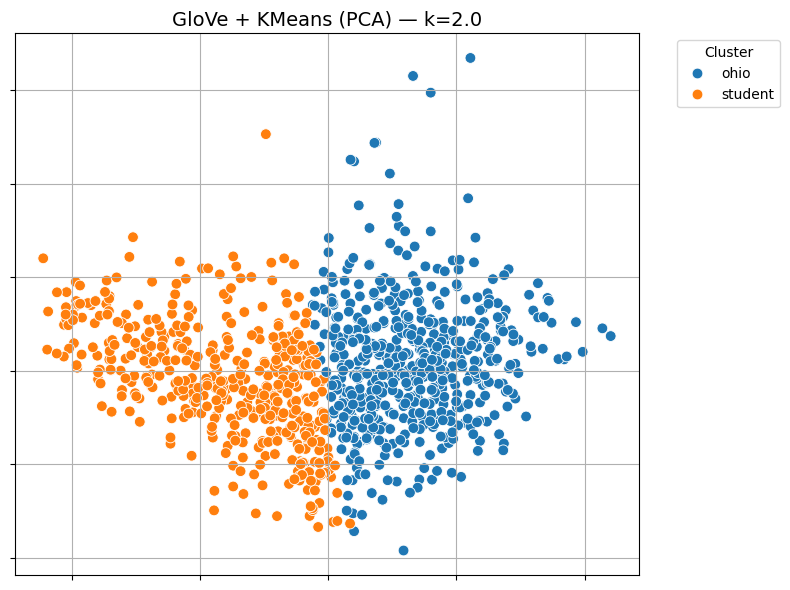

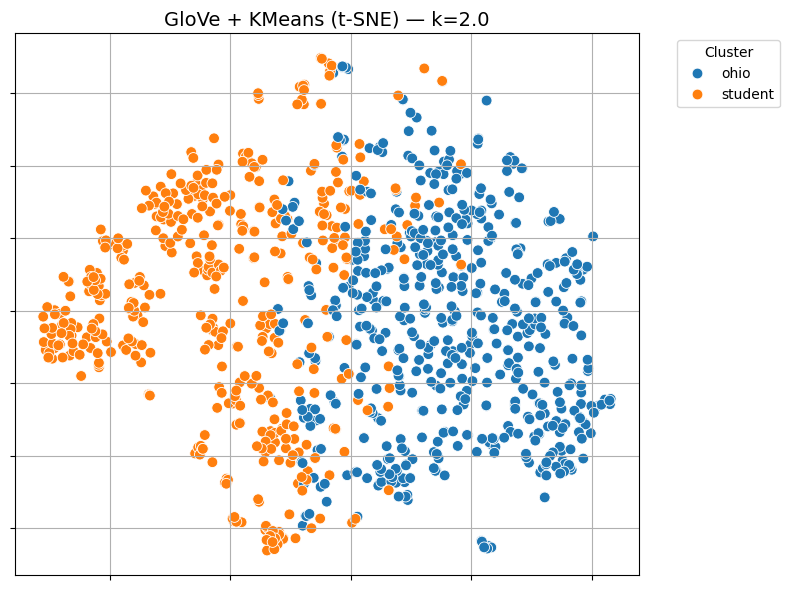

C:\Users\ROHITH\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


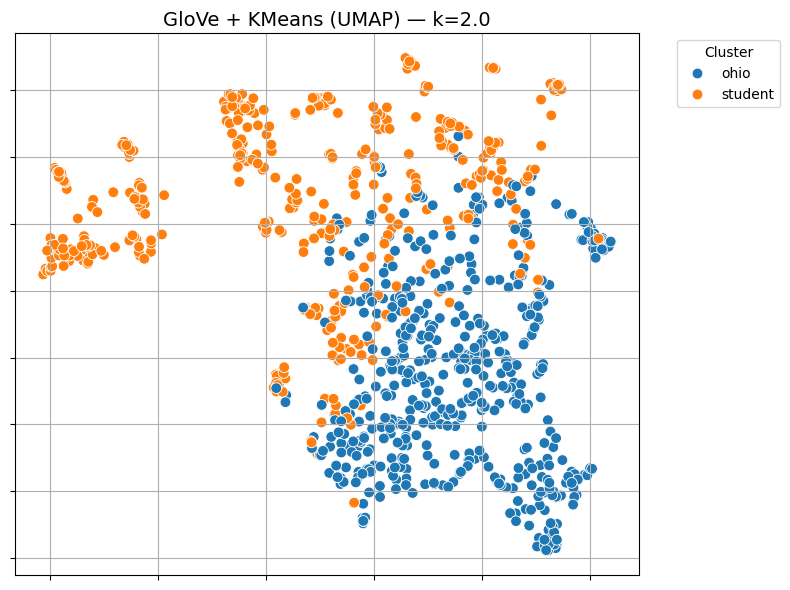

In [97]:
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# ✅ Ensure Cleaned_Content is a list
if "Evaluated_Tokens" not in df.columns:
    df["Evaluated_Tokens"] = df["Cleaned_Tokens"].apply(
        lambda x: ast.literal_eval(x) if isinstance(x, str) else x
    )

# 🧠 Get top keywords from token lists
def get_top_keywords(token_lists, top_n=20):
    all_words = [word for tokens in token_lists if isinstance(tokens, list) for word in tokens]
    most_common = Counter(all_words).most_common(top_n)
    return [word for word, _ in most_common]

# 🔖 Pick best label (unique, interpretable, no repeated words)
def pick_label(keywords, used_labels, used_tokens):
    ignore = {
        "university", "findlay", "uf", "students", "said", "views",
        "shares", "facebook", "tweet", "new", "best"
    }

    # Try single word, then two-word, then three-word phrases
    for i in range(len(keywords)):
        candidate = "_".join(keywords[: i+1])  
        candidate_tokens = set(candidate.split("_"))

        if (
            candidate.lower() not in ignore
            and candidate not in used_labels
            and candidate_tokens.isdisjoint(used_tokens)
        ):
            return candidate, candidate_tokens

    # Try extended keywords (11–20)
    if len(keywords) > 10:
        for i in range(10, len(keywords)):
            candidate = keywords[i]
            if (
                candidate.lower() not in ignore
                and candidate not in used_labels
                and candidate not in used_tokens
            ):
                return candidate, {candidate}

    # Fallback
    fallback = f"theme_{len(used_labels)}"
    return fallback, {fallback}

# 🔖 Generate cluster labels
cluster_labels = {}
used_labels = set()
used_tokens = set()

print("📌 Final Cluster Labels with Top Keywords (GloVe + KMeans):\n")
for cluster_id in sorted(df["GloVe_FinalCluster"].unique()):
    token_lists = df[df["GloVe_FinalCluster"] == cluster_id]["Evaluated_Tokens"]
    top_words = get_top_keywords(token_lists, top_n=20)
    label, label_tokens = pick_label(top_words, used_labels, used_tokens)

    cluster_labels[cluster_id] = label
    used_labels.add(label)
    used_tokens.update(label_tokens)

    # Print results
    print(f"Cluster {cluster_id} → Label: '{label}'")
    print(f"   Top Keywords: {top_words[:10]}\n")

# Add labels to DataFrame
df["GloVe_Cluster_Label"] = df["GloVe_FinalCluster"].map(cluster_labels)

# 🔍 Visualization function using labels
def plot_clusters_2D(data_2d, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=data_2d[:, 0], 
        y=data_2d[:, 1], 
        hue=labels, 
        palette="tab10", 
        s=60
    )
    plt.title(title, fontsize=14)
    plt.xlabel("")   # remove axis label
    plt.ylabel("")   # remove axis label
    plt.grid(True)   # keep grid lines
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# ✅ PCA
glove_pca = PCA(n_components=2, random_state=42).fit_transform(glove_vectors)
plot_clusters_2D(glove_pca, df["GloVe_Cluster_Label"], f"GloVe + KMeans (PCA) — k={best_k_glove}")

# ✅ t-SNE
glove_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(glove_vectors)
plot_clusters_2D(glove_tsne, df["GloVe_Cluster_Label"], f"GloVe + KMeans (t-SNE) — k={best_k_glove}")

# ✅ UMAP
glove_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(glove_vectors)
plot_clusters_2D(glove_umap, df["GloVe_Cluster_Label"], f"GloVe + KMeans (UMAP) — k={best_k_glove}")


###  Save Final Scores (GloVe + KMeans)  
- Extract **Silhouette Score** and **Davies-Bouldin Index** for the selected best k.  
- Store results in a one-row summary DataFrame.  
- Append scores to the main results file (`model_scores_word2vec_kmeans.csv`).  
- Maintain consistent evaluation records across embedding models.  


In [100]:
# ✅ Extract scores for best_k_glove
sil_score_glove = round(glove_averages_df.loc[glove_averages_df["k"] == best_k_glove, "Silhouette Score"].values[0], 4)
db_score_glove = round(glove_averages_df.loc[glove_averages_df["k"] == best_k_glove, "Davies-Bouldin Index"].values[0], 4)

# ✅ Create one-row DataFrame with final scores
final_score_row_glove = pd.DataFrame([{
    "Embedding": "GloVe",
    "Clustering": "KMeans",
    "Best_k": int(best_k_glove),
    "Silhouette_Score": sil_score_glove,
    "Davies_Bouldin_Index": db_score_glove
}])

# ✅ Append to existing file (no header)
final_score_row_glove.to_csv("model_scores_word2vec_kmeans.csv", mode='a', index=False, header=False)

print("✅ Saved GloVe + KMeans final scores to 'model_scores_word2vec_kmeans.csv'")


✅ Saved GloVe + KMeans final scores to 'model_scores_word2vec_kmeans.csv'


###  Data Collection +  Embedding (BERT)  + KMeans
- Load the cleaned dataset of **1000 articles**.  
- Use **Sentence Transformers (MiniLM)** to generate BERT embeddings.  
- Convert token lists back into text strings for embedding.  
- Encode articles into dense vectors for clustering.  


In [104]:
# 📘 Step 1: Load Cleaned Dataset
import pandas as pd

# Load cleaned file (must contain Cleaned_Text column)
df = pd.read_csv("uf_newsroom_1000_articles_cleaned.csv")

print(f"✅ Loaded cleaned dataset with {df.shape[0]} articles.")

# 🧠 Use Sentence Transformers for BERT embeddings
from sentence_transformers import SentenceTransformer

# Load pre-trained BERT model (MiniLM)
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

# ✅ Use Cleaned_Text column (full sentences, minimal preprocessing)
text_data = df["Cleaned_Text"].astype(str).tolist()

# Get BERT embeddings
bert_embeddings = bert_model.encode(text_data, show_progress_bar=True)

print(f"✅ BERT embeddings generated. Shape: {bert_embeddings.shape}")


✅ Loaded cleaned dataset with 1000 articles.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

✅ BERT embeddings generated. Shape: (1000, 384)


###  Clustering (BERT + KMeans, 20 runs per k = 2–15)  
- Apply **KMeans clustering** to BERT embeddings.  
- Run for k = 2 to 15, repeating each setting **20 times**.  
- Record **Silhouette Score** (higher = better) and **Davies-Bouldin Index** (lower = better).  
- Save results to `bert_kmeans_20runs.csv` for later analysis.  


In [105]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tqdm import tqdm
import pandas as pd
import numpy as np

# 🔁 Run KMeans 20 times for each k
bert_kmeans_results = []
print("\n🔁 Running KMeans 20 times for each k (2 to 15)...\n")

for k in tqdm(range(2, 16), desc="Evaluating k values"):
    for run in range(20):
        kmeans = KMeans(n_clusters=k, random_state=run, n_init=10)
        labels = kmeans.fit_predict(bert_embeddings)

        sil = silhouette_score(bert_embeddings, labels)
        dbi = davies_bouldin_score(bert_embeddings, labels)

        bert_kmeans_results.append({
            "k": k,
            "Run": run + 1,
            "Silhouette Score": round(sil, 4),
            "Davies-Bouldin Index": round(dbi, 4)
        })

# Save to CSV
bert_kmeans_df = pd.DataFrame(bert_kmeans_results)
bert_kmeans_df.to_csv("bert_kmeans_20runs.csv", index=False)

print("✅ Saved BERT KMeans 20-run evaluation results to 'bert_kmeans_20runs.csv'")



🔁 Running KMeans 20 times for each k (2 to 15)...



Evaluating k values: 100%|██████████| 14/14 [02:11<00:00,  9.43s/it]

✅ Saved BERT KMeans 20-run evaluation results to 'bert_kmeans_20runs.csv'


###  Evaluation (BERT + KMeans)  
- Load the **20-run results** from CSV.  
- Compute average **Silhouette Score** and **Davies-Bouldin Index** for each k.  
- Round values for clarity.  
- Display the comparison table to observe clustering performance across k values.  


In [109]:
# Load CSV
bert_kmeans_df = pd.read_csv("bert_kmeans_20runs.csv")

# Group and average
bert_avg_scores = bert_kmeans_df.groupby("k").agg({
    "Silhouette Score": "mean",
    "Davies-Bouldin Index": "mean"
}).reset_index()

# Round for display
bert_avg_scores["Silhouette Score"] = bert_avg_scores["Silhouette Score"].round(4)
bert_avg_scores["Davies-Bouldin Index"] = bert_avg_scores["Davies-Bouldin Index"].round(4)

# Display
from IPython.display import display
display(bert_avg_scores)


k  Silhouette Score  Davies-Bouldin Index
0    2            0.0807                3.5444
1    3            0.0804                3.1578
2    4            0.0719                3.1966
3    5            0.0673                3.3687
4    6            0.0682                3.2528
5    7            0.0678                3.1915
6    8            0.0708                3.1105
7    9            0.0714                3.0919
8   10            0.0720                3.0457
9   11            0.0718                3.0224
10  12            0.0724                3.0161
11  13            0.0735                3.0002
12  14            0.0734                2.9738
13  15            0.0743                2.9713

###  Score Visualization (BERT + KMeans)  
- Plot **Silhouette Score vs k** to identify where clustering quality peaks.  
- Plot **Davies-Bouldin Index vs k** to check where cluster separation is strongest.  
- Compare both metrics together to guide best k selection.  


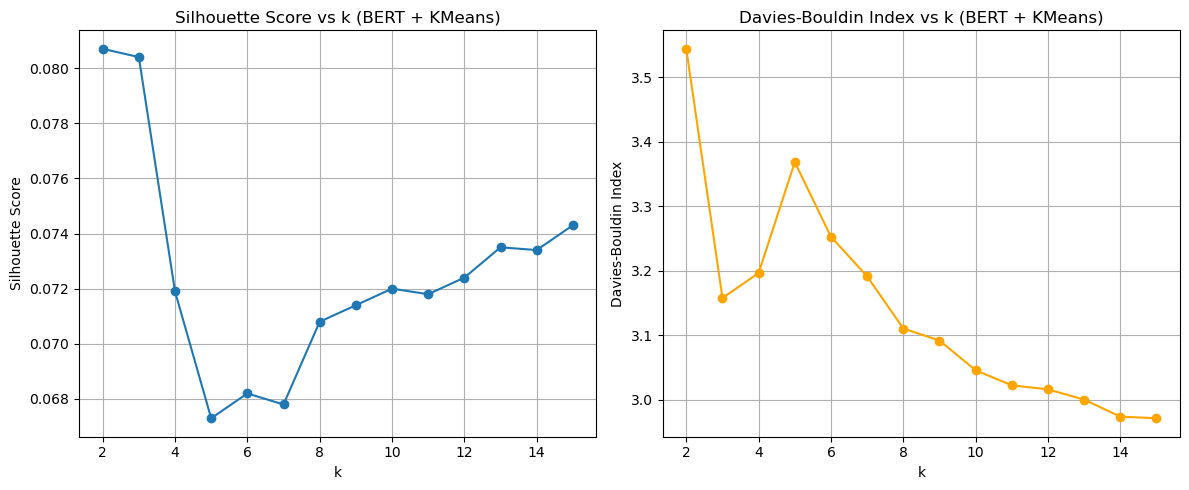

In [115]:
import matplotlib.pyplot as plt

# Plot Silhouette Score
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(bert_avg_scores["k"], bert_avg_scores["Silhouette Score"], marker='o')
plt.title("Silhouette Score vs k (BERT + KMeans)")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)

# Plot Davies-Bouldin Index
plt.subplot(1, 2, 2)
plt.plot(bert_avg_scores["k"], bert_avg_scores["Davies-Bouldin Index"], marker='o', color='orange')
plt.title("Davies-Bouldin Index vs k (BERT + KMeans)")
plt.xlabel("k")
plt.ylabel("Davies-Bouldin Index")
plt.grid(True)

plt.tight_layout()
plt.show()


###  Best k Selection (BERT + KMeans)  
- Automatically identify the **optimal k** by maximizing **Silhouette Score** and minimizing **Davies-Bouldin Index**.  
- Select the k value that provides the best overall clustering performance.  
- Print the chosen **best k** for BERT + KMeans.  


In [118]:
# Create a combined metric that rewards high Silhouette and low DBI
# Here, DBI is scaled down (0.01 factor) so it doesn't dominate the score
bert_avg_scores["Combined_Score"] = (
    bert_avg_scores["Silhouette Score"] - 0.01 * bert_avg_scores["Davies-Bouldin Index"]
)

# Pick k with the highest combined score
best_k_bert = int(bert_avg_scores.loc[bert_avg_scores["Combined_Score"].idxmax(), "k"])

print("✅ Best k for BERT + KMeans (balanced Silhouette & DBI):", best_k_bert)


✅ Best k for BERT + KMeans (balanced Silhouette & DBI): 3


In [120]:
from sklearn.cluster import KMeans

# ✅ Use the best k selected from the balanced evaluation
best_k_bert = int(best_k_bert)  # ensure it's int, not float

# Run final KMeans clustering
final_bert_kmeans = KMeans(
    n_clusters=best_k_bert, 
    random_state=42, 
    n_init=10
)
df["BERT_FinalCluster"] = final_bert_kmeans.fit_predict(bert_embeddings)

print(f"✅ Assigned BERT_FinalCluster using balanced best_k = {best_k_bert}")


✅ Assigned BERT_FinalCluster using balanced best_k = 3


### Cluster Labeling & Visualization (BERT + KMeans)  
- Convert `Cleaned_Content` into token lists.  
- Extract **top keywords** per cluster for labeling.  
- Generate **unique labels** (skip filler words, allow multi-word phrases).  
- Print final labels with top 10 keywords.  
- Visualize clusters with **PCA, t-SNE, and UMAP** for comparison.  


📌 Final Cluster Labels with Top Keywords (BERT + KMeans):

Cluster 0 → Label: 'student_program'
   Top Keywords: ['student', 'program', 'college', 'year', 'campus', 'news', 'community', 'share', 'education', 'home']

Cluster 1 → Label: 'event_art'
   Top Keywords: ['student', 'event', 'art', 'campus', 'perform', 'news', 'share', 'home', 'release', 'year']

Cluster 2 → Label: 'museum_mazza'
   Top Keywords: ['museum', 'mazza', 'book', 'art', 'artist', 'event', 'feature', 'include', 'child', 'news']



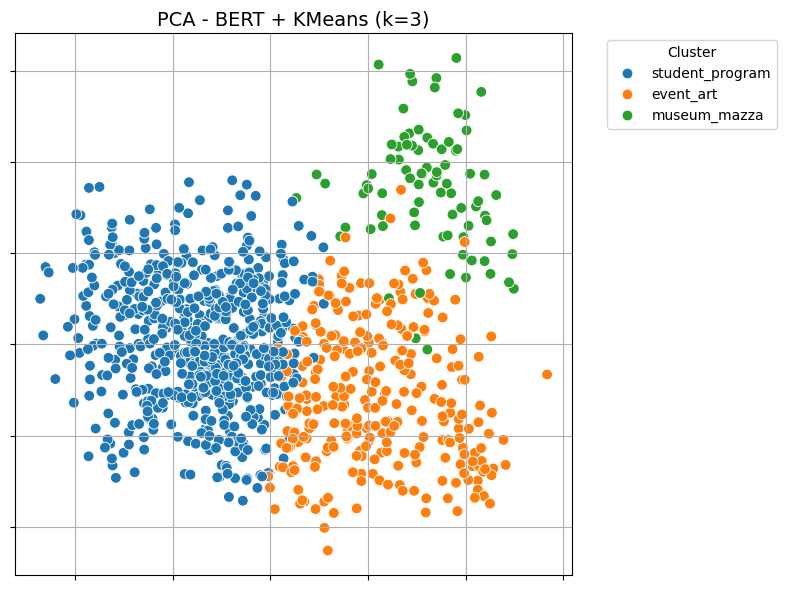

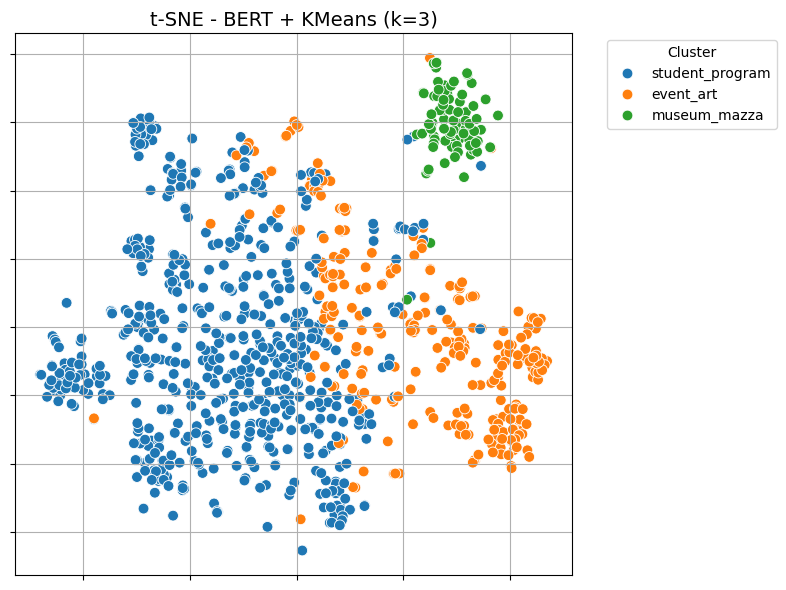

C:\Users\ROHITH\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


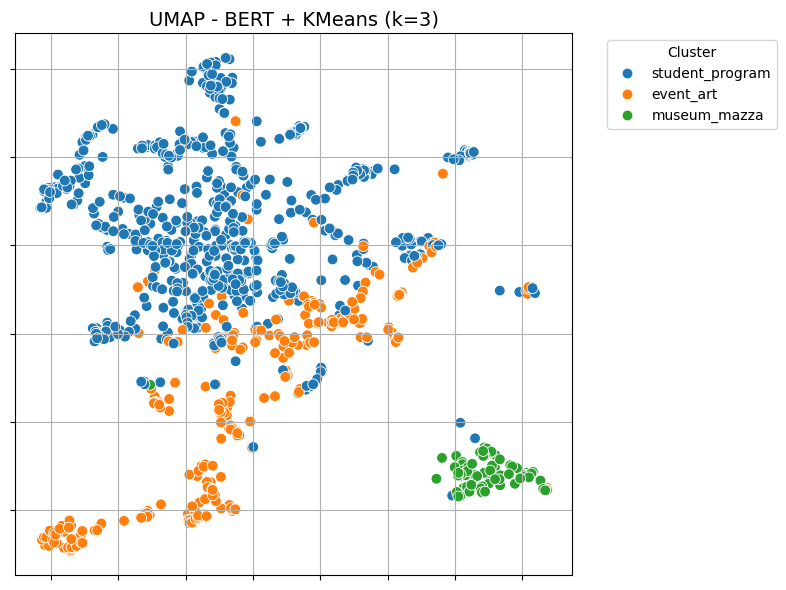

In [133]:
import ast
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# ✅ Ensure Cleaned_Content is a list (not stringified)
df["Cleaned_Tokens"] = df["Cleaned_Tokens"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# 🧠 Function to get top keywords from token lists
def get_top_keywords(token_lists, top_n=20):
    all_words = [word for tokens in token_lists if isinstance(tokens, list) for word in tokens]
    most_common = Counter(all_words).most_common(top_n)
    return [word for word, _ in most_common]

# 🔖 Improved function to choose best label (prefer multi-word phrases)
def pick_label(keywords, used_labels, used_tokens):
    stop_words = {
        "university", "uf", "findlay", "students", "facebook", "shares",
        "tweet", "views", "also", "one", "will", "said", "year", "new", "event", "best", "show"
    }

    # Try bigram → trigram → unigram for clearer labels
    for n in [2, 3, 1]:
        if len(keywords) >= n:
            for i in range(len(keywords) - n + 1):
                candidate = "_".join(keywords[i:i+n])
                candidate_tokens = set(candidate.split("_"))
                if (
                    candidate.lower() not in stop_words
                    and candidate not in used_labels
                    and candidate_tokens.isdisjoint(used_tokens)
                ):
                    return candidate, candidate_tokens

    # Extended fallback (check beyond top 10)
    if len(keywords) > 10:
        for i in range(10, len(keywords)):
            candidate = keywords[i]
            if (
                candidate.lower() not in stop_words
                and candidate not in used_labels
                and candidate not in used_tokens
            ):
                return candidate, {candidate}

    # Final fallback
    fallback = f"theme_{len(used_labels)}"
    return fallback, {fallback}

# 🔖 Generate cluster labels
cluster_labels = {}
used_labels = set()
used_tokens = set()

print("📌 Final Cluster Labels with Top Keywords (BERT + KMeans):\n")
for cluster_id in sorted(df["BERT_FinalCluster"].unique()):
    cluster_tokens = df[df["BERT_FinalCluster"] == cluster_id]["Cleaned_Tokens"]
    top_words = get_top_keywords(cluster_tokens.tolist(), top_n=20)
    label, label_tokens = pick_label(top_words, used_labels, used_tokens)

    cluster_labels[cluster_id] = label
    used_labels.add(label)
    used_tokens.update(label_tokens)

    # Print results for review
    print(f"Cluster {cluster_id} → Label: '{label}'")
    print(f"   Top Keywords: {top_words[:10]}\n")

# 🗂️ Apply labels back to DataFrame
df["BERT_Cluster_Label"] = df["BERT_FinalCluster"].map(cluster_labels)

# 📊 Visualization function
def plot_2D(data_2d, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=data_2d[:, 0], 
        y=data_2d[:, 1], 
        hue=labels, 
        palette="tab10", 
        s=60
    )
    plt.title(title, fontsize=14)
    plt.xlabel("")   
    plt.ylabel("")   
    plt.grid(True)   
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 🔢 Visualizations: PCA, t-SNE, UMAP
X_pca = PCA(n_components=2, random_state=42).fit_transform(bert_embeddings)
plot_2D(X_pca, df["BERT_Cluster_Label"], f"PCA - BERT + KMeans (k={best_k_bert})")

X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(bert_embeddings)
plot_2D(X_tsne, df["BERT_Cluster_Label"], f"t-SNE - BERT + KMeans (k={best_k_bert})")

X_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(bert_embeddings)
plot_2D(X_umap, df["BERT_Cluster_Label"], f"UMAP - BERT + KMeans (k={best_k_bert})")


In [135]:
# 📂 Load the 20-run results for BERT + KMeans
import pandas as pd

bert_kmeans_scores_df = pd.read_csv("bert_kmeans_20runs.csv")

# 📊 Compute average scores for each k
bert_averages_df = bert_kmeans_scores_df.groupby("k").agg({
    "Silhouette Score": "mean",
    "Davies-Bouldin Index": "mean"
}).reset_index()

# Round for clarity
bert_averages_df["Silhouette Score"] = bert_averages_df["Silhouette Score"].round(4)
bert_averages_df["Davies-Bouldin Index"] = bert_averages_df["Davies-Bouldin Index"].round(4)

# ✅ Show result
bert_averages_df


k  Silhouette Score  Davies-Bouldin Index
0    2            0.0807                3.5444
1    3            0.0804                3.1578
2    4            0.0719                3.1966
3    5            0.0673                3.3687
4    6            0.0682                3.2528
5    7            0.0678                3.1915
6    8            0.0708                3.1105
7    9            0.0714                3.0919
8   10            0.0720                3.0457
9   11            0.0718                3.0224
10  12            0.0724                3.0161
11  13            0.0735                3.0002
12  14            0.0734                2.9738
13  15            0.0743                2.9713

###  Save Final Scores (BERT + KMeans)  
- Confirm `best_k_bert` is stored as an integer.  
- Extract the **Silhouette Score** and **Davies-Bouldin Index** for the best k.  
- Store results in a summary DataFrame.  
- Append the final BERT + KMeans scores to the cumulative results file (`model_scores_word2vec_kmeans.csv`).  


In [138]:
# ✅ Ensure best_k_bert is int
best_k_bert = int(best_k_bert)

# ✅ Extract scores for best k
sil_score_bert = round(bert_averages_df.loc[bert_averages_df["k"] == best_k_bert, "Silhouette Score"].values[0], 4)
dbi_score_bert = round(bert_averages_df.loc[bert_averages_df["k"] == best_k_bert, "Davies-Bouldin Index"].values[0], 4)

# ✅ Save to cumulative results
bert_kmeans_result = pd.DataFrame([{
    "Embedding": "BERT",
    "Clustering": "KMeans",
    "Best_k": best_k_bert,
    "Silhouette_Score": sil_score_bert,
    "Davies_Bouldin_Index": dbi_score_bert
}])

bert_kmeans_result.to_csv("model_scores_word2vec_kmeans.csv", mode='a', index=False, header=False)

print("✅ Final scores for BERT + KMeans appended.")


✅ Final scores for BERT + KMeans appended.


###  Embedding (Word2Vec for Hierarchical Clustering)  
- Train a **Word2Vec model** on the cleaned tokenized articles.  
- Generate document vectors by averaging word embeddings for each article.  
- Create the final **Word2Vec document vector matrix** for clustering.  
- Save vectors to `w2v_hier_doc_vectors.pkl` for reuse in hierarchical clustering.  


In [197]:
# 🧠 Word2Vec Embeddings for Hierarchical Clustering
from gensim.models import Word2Vec
import numpy as np
import pickle

# ✅ Token list (assumed already cleaned)
token_lists_w2v_hier = df["Cleaned_Tokens"].tolist()

# ✅ Train Word2Vec model (specific for hierarchical)
w2v_hier_model = Word2Vec(
    sentences=token_lists_w2v_hier,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    seed=42
)
w2v_hier_model.train(token_lists_w2v_hier, total_examples=len(token_lists_w2v_hier), epochs=10)

# ✅ Convert tokens to document vectors
def get_mean_vector(tokens, model, vector_size=100):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

w2v_hier_doc_vectors = np.array([
    get_mean_vector(tokens, w2v_hier_model, 100) for tokens in token_lists_w2v_hier
])

print(f"✅ Word2Vec Hierarchical document vectors created. Shape: {w2v_hier_doc_vectors.shape}")

# 💾 Save to file
with open("w2v_hier_doc_vectors.pkl", "wb") as f:
    pickle.dump(w2v_hier_doc_vectors, f)
print("💾 Saved vectors to w2v_hier_doc_vectors.pkl")


✅ Word2Vec Hierarchical document vectors created. Shape: (1000, 100)
💾 Saved vectors to w2v_hier_doc_vectors.pkl


###  Clustering + Dendrogram (Word2Vec + Hierarchical, n = 2,7,13)  
- Load the **Word2Vec document vectors** from pickle.  
- Perform hierarchical clustering using **Ward’s linkage**.  
- Automatically select a cutoff distance to formn**n = 2 clusters**.  
- Assign cluster labels to the dataset.  
- Extract **top keywords** for each cluster to improve interpretability.  
- Plot a **dendrogram** with cutoff line and keyword-based labels.  
- Print top keywords for both clusters.  



🔍 Searching cutoff for target n=2...
✅ Selected cutoff = 1.25 → 2 clusters (target=2)
Distance range: 1.26 → 0.01


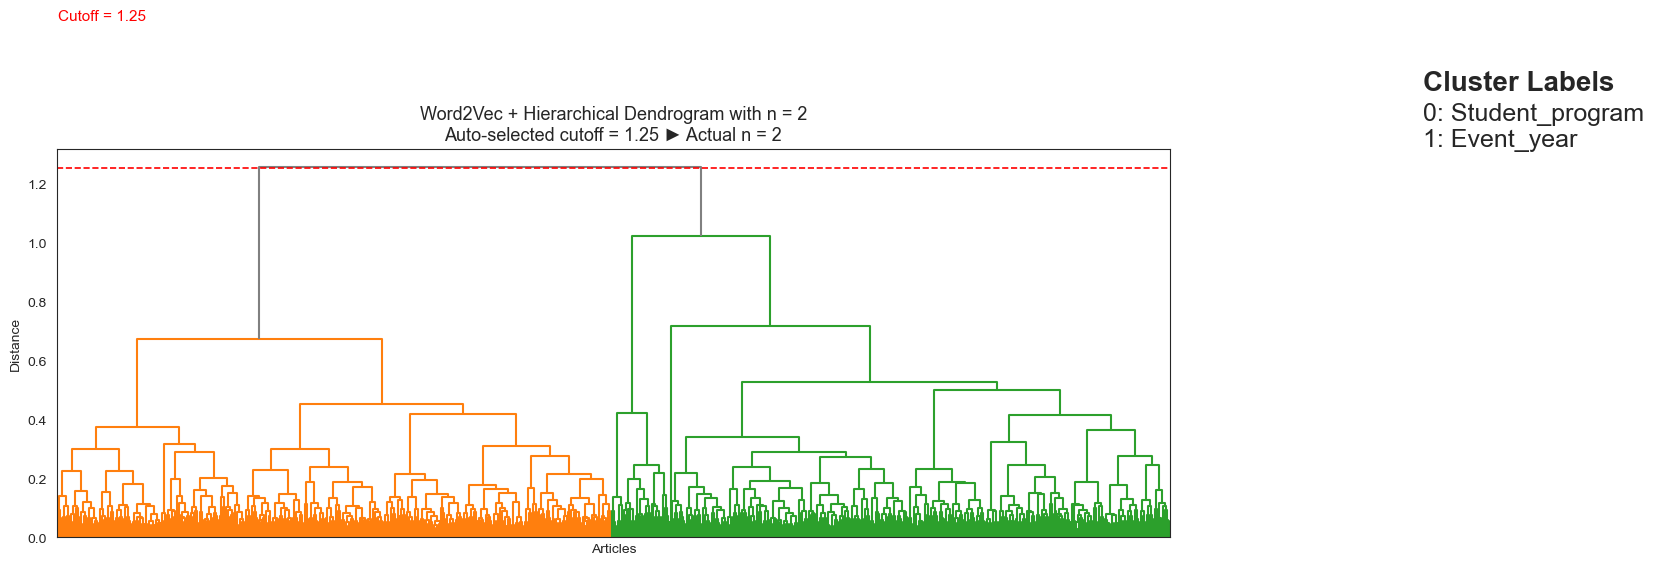


⭐ Top Keywords for n=2:
Cluster 0 → (Student_program) = ['student', 'program', 'college', 'campus', 'news', 'community', 'year', 'education', 'share', 'event']
Cluster 1 → (Event_year) = ['student', 'event', 'year', 'campus', 'art', 'news', 'home', 'share', 'college', 'post']

🔍 Searching cutoff for target n=7...
✅ Selected cutoff = 0.5 → 7 clusters (target=7)
Distance range: 1.26 → 0.01


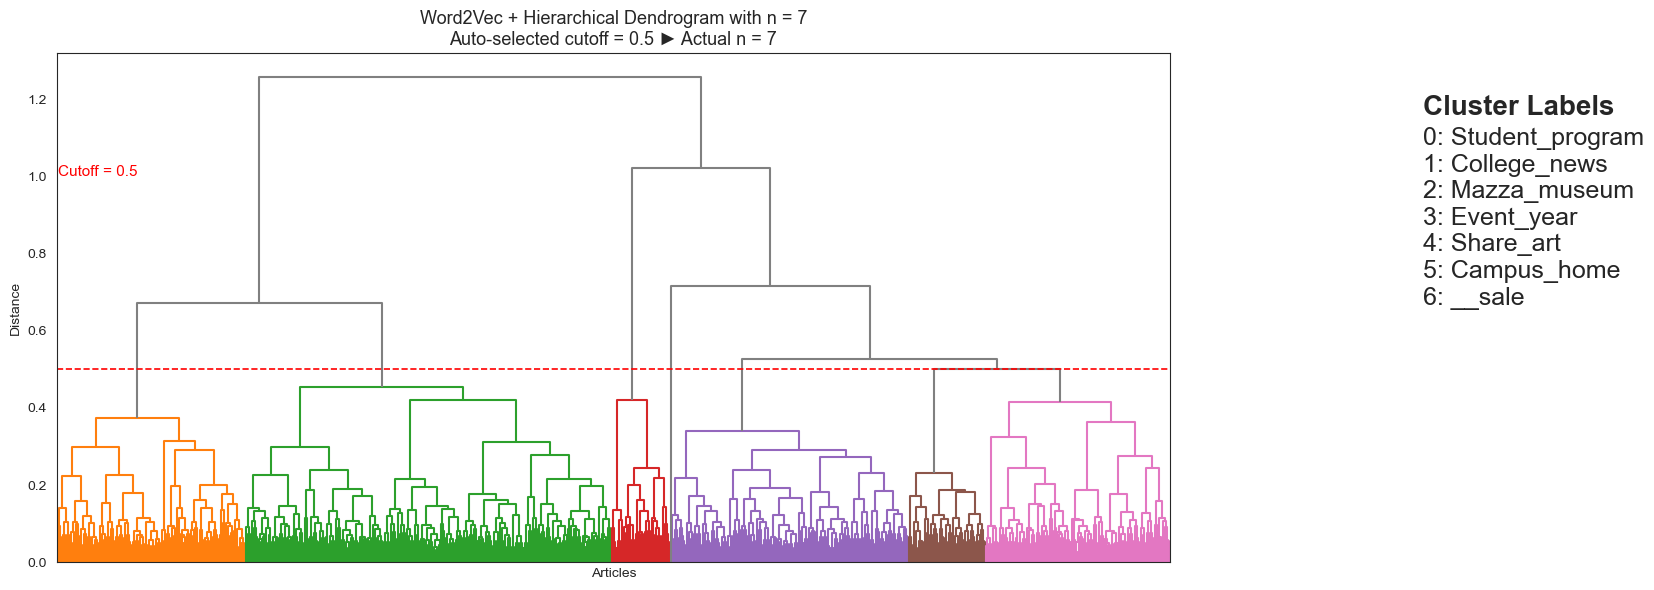


⭐ Top Keywords for n=7:
Cluster 0 → (Student_program) = ['student', 'program', 'college', 'pharmacy', 'professor', 'year', 'news', 'education', 'community', 'faculty']
Cluster 1 → (College_news) = ['student', 'campus', 'program', 'college', 'news', 'community', 'year', 'education', 'event', 'share']
Cluster 2 → (Mazza_museum) = ['mazza', 'museum', 'event', 'art', 'sunday', 'news', 'funday', 'feature', 'book', 'artist']
Cluster 3 → (Event_year) = ['student', 'college', 'event', 'year', 'campus', 'news', 'home', 'program', 'share', 'work']
Cluster 4 → (Share_art) = ['student', 'campus', 'event', 'community', 'news', 'share', 'art', 'home', 'release', 'post']
Cluster 5 → (Campus_home) = ['year', 'student', 'art', 'book', 'event', 'campus', 'home', 'news', 'include', 'share']
Cluster 6 → (__sale) = ['_', 'sale', 'horse', 'equestrian', 'spring', 'annual', 'western', 'program', 'feature', 'student']

🔍 Searching cutoff for target n=13...
✅ Selected cutoff = 0.36 → 13 clusters (target=13)
Di

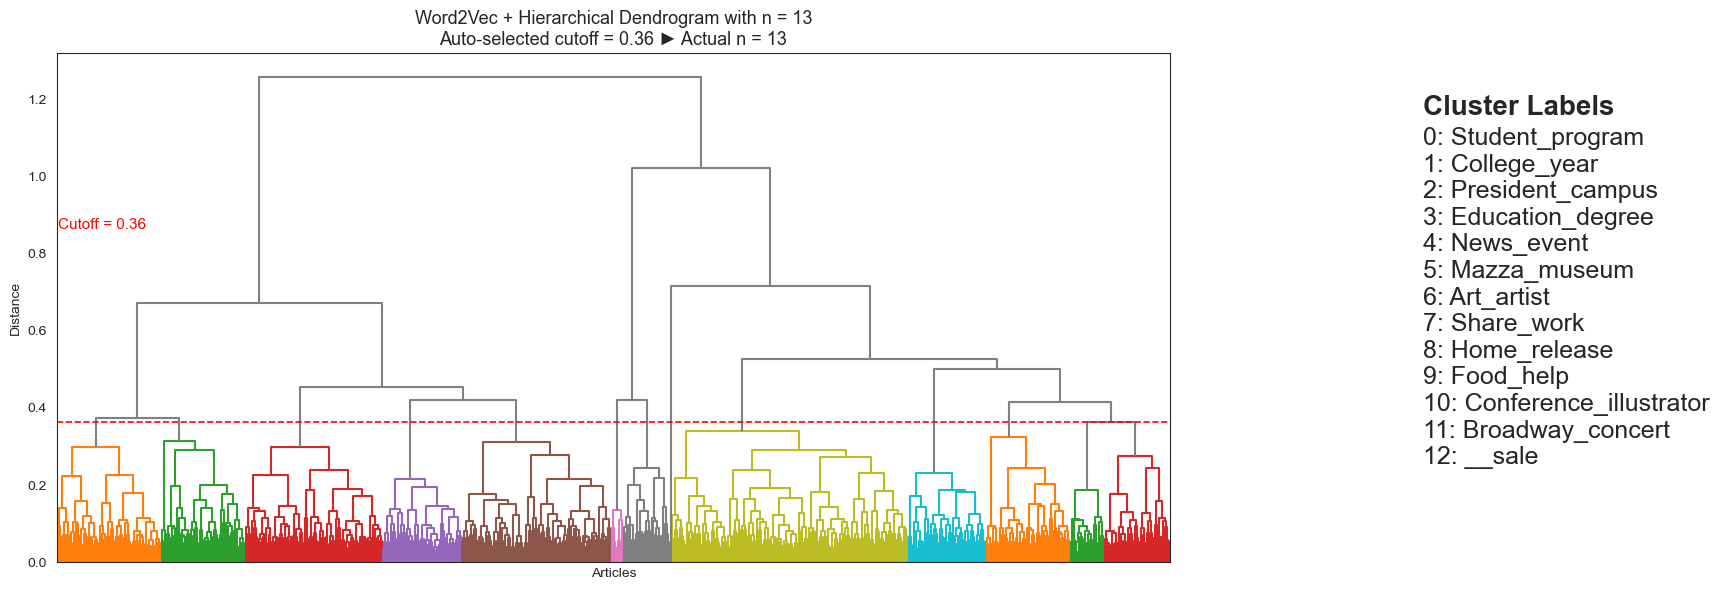


⭐ Top Keywords for n=13:
Cluster 0 → (Student_program) = ['student', 'program', 'college', 'professor', 'research', 'health', 'year', 'news', 'faculty', 'share']
Cluster 1 → (College_year) = ['student', 'pharmacy', 'program', 'college', 'year', 'professor', 'scholarship', 'ohio', 'school', 'education']
Cluster 2 → (President_campus) = ['student', 'college', 'news', 'year', 'community', 'program', 'president', 'campus', 'business', 'education']
Cluster 3 → (Education_degree) = ['program', 'student', 'college', 'education', 'degree', 'graduate', 'ohio', 'news', 'school', 'year']
Cluster 4 → (News_event) = ['student', 'campus', 'community', 'program', 'news', 'event', 'give', 'day', 'share', 'college']
Cluster 5 → (Mazza_museum) = ['mazza', 'museum', 'sunday', 'funday', 'event', 'feature', 'theme', 'amanda', 'davidson', 'johnston']
Cluster 6 → (Art_artist) = ['museum', 'mazza', 'art', 'artist', 'event', 'book', 'news', 'share', 'feature', 'home']
Cluster 7 → (Share_work) = ['student', 'c

In [216]:
# --------------------------------------------
# 📊 Plot dendrograms for each target_n (Auto-adaptive cutoff)
# --------------------------------------------
for target_n in target_ns:
    print(f"\n🔍 Searching cutoff for target n={target_n}...")

    # Compute actual min/max linkage distances
    min_d, max_d = linkage_matrix[:, 2].min(), linkage_matrix[:, 2].max()
    thresholds = np.linspace(max_d, min_d, 800)

    best_cutoff, best_diff = None, float("inf")
    best_labels = None

    for threshold in thresholds:
        labels = fcluster(linkage_matrix, threshold, criterion="distance")
        n_clusters = len(set(labels))
        diff = abs(n_clusters - target_n)
        if diff < best_diff:
            best_diff = diff
            best_cutoff = threshold
            best_labels = labels
        if n_clusters == target_n:
            break

    auto_cutoff = best_cutoff
    labels = best_labels

    print(f"✅ Selected cutoff = {round(auto_cutoff, 2)} → {len(set(labels))} clusters (target={target_n})")
    print(f"Distance range: {round(max_d, 2)} → {round(min_d, 2)}")

    # 🏷️ Assign clusters
    df[f"Cluster_n{target_n}"] = labels

    # 🧠 Extract top keywords + labels
    cluster_keywords = {}
    cluster_labels = {}
    used_labels, used_tokens = set(), set()

    for cluster_id in sorted(set(labels)):
        cluster_df = df[df[f"Cluster_n{target_n}"] == cluster_id]
        tokens = cluster_df["Cleaned_Tokens"].tolist()
        top_words = get_top_keywords(tokens, top_n=10)
        cluster_keywords[cluster_id] = top_words
        cluster_labels[cluster_id] = pick_label(top_words, used_labels, used_tokens)

    # --------------------------------------------
    # 📈 Plot dendrogram (clean and readable)
    # --------------------------------------------
    plt.figure(figsize=(14, 6))
    dendrogram(
        linkage_matrix,
        color_threshold=auto_cutoff,
        above_threshold_color="grey",
        no_labels=True
    )

    plt.axhline(y=auto_cutoff, color="red", linestyle="--", linewidth=1.2)
    plt.text(10, auto_cutoff + 0.5, f"Cutoff = {round(auto_cutoff, 2)}", color="red", fontsize=11)

    plt.title(
        f"Word2Vec + Hierarchical Dendrogram with n = {target_n}\n"
        f"Auto-selected cutoff = {round(auto_cutoff, 2)} ► Actual n = {len(set(labels))}",
        fontsize=13
    )
    plt.xlabel("Articles")
    plt.ylabel("Distance")

    legend_texts = [f"{i}: {cluster_labels[cid]}" for i, cid in enumerate(sorted(cluster_labels.keys()))]
    legend_string = "\n".join(legend_texts)
    plt.gcf().text(1.02, 0.8, "Cluster Labels", fontsize=20, fontweight="bold")
    plt.gcf().text(1.02, 0.78, legend_string, fontsize=18, va="top", ha="left")

    plt.tight_layout(rect=[0, 0, 0.85, 1])  # avoid margin warnings
    plt.show()

    # ✅ Print keywords per cluster
    print(f"\n⭐ Top Keywords for n={target_n}:")
    for i, cid in enumerate(sorted(cluster_keywords.keys())):
        print(f"Cluster {i} → ({cluster_labels[cid]}) = {cluster_keywords[cid]}")


✅ Selected cutoff = 0.36 → 13 clusters (target=13)


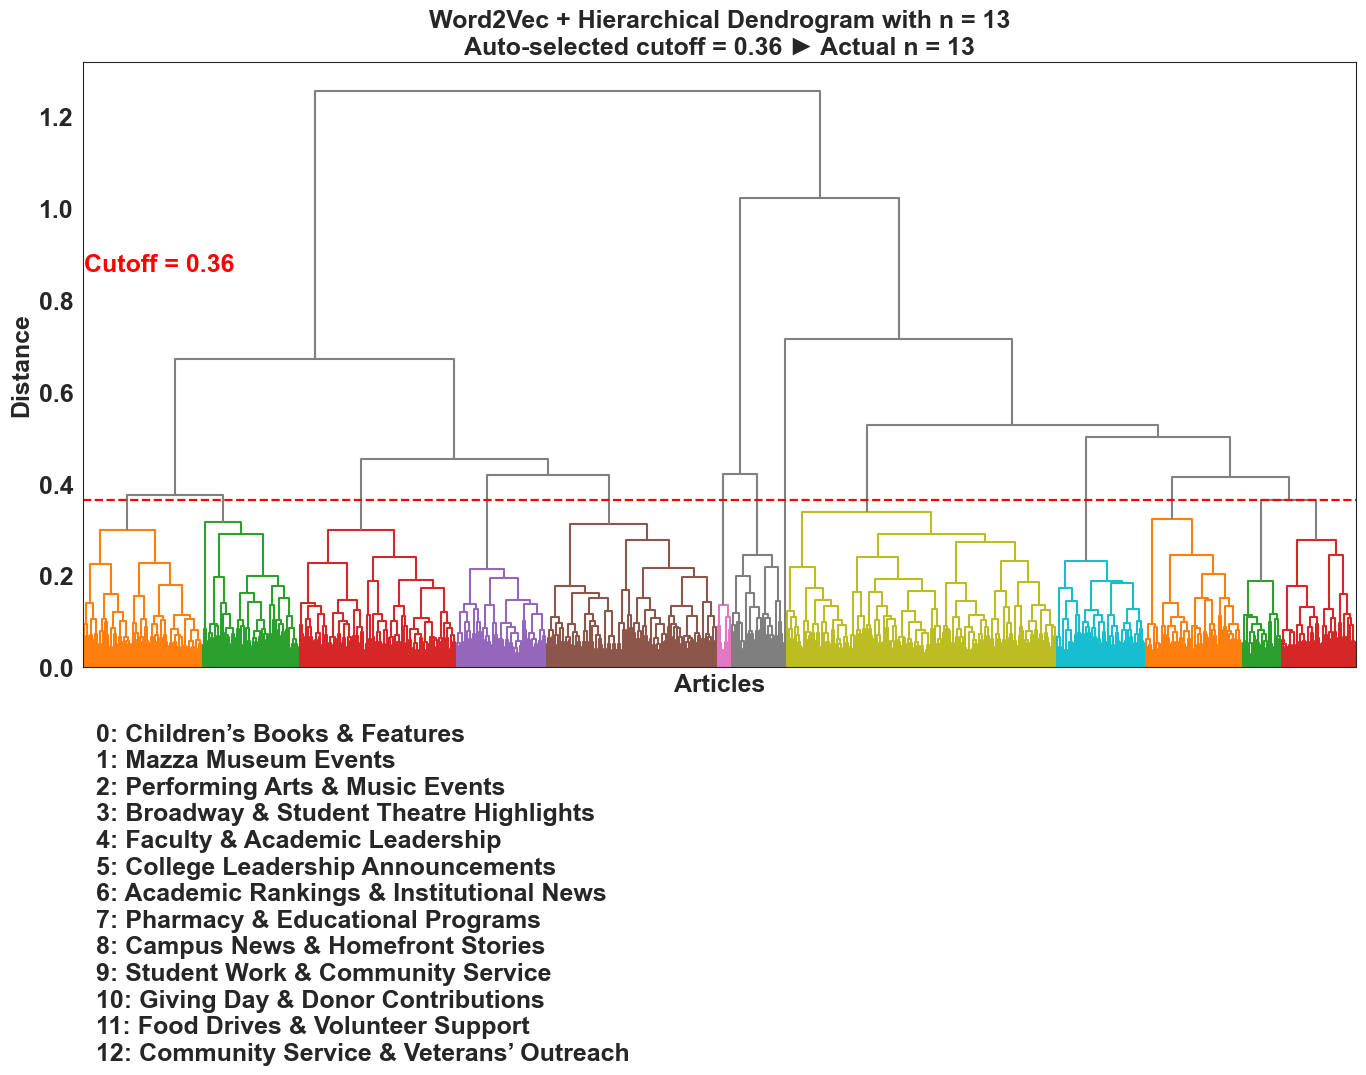


⭐ Top Keywords for n = 13:
1 → (Mazza Museum Events) = ['student', 'program', 'college', 'professor', 'research', 'health', 'year', 'news', 'faculty', 'share']
2 → (Performing Arts & Music Events) = ['student', 'pharmacy', 'program', 'college', 'year', 'professor', 'scholarship', 'ohio', 'school', 'education']
3 → (Broadway & Student Theatre Highlights) = ['student', 'college', 'news', 'year', 'community', 'program', 'president', 'campus', 'business', 'education']
4 → (Faculty & Academic Leadership) = ['program', 'student', 'college', 'education', 'degree', 'graduate', 'ohio', 'news', 'school', 'year']
5 → (College Leadership Announcements) = ['student', 'campus', 'community', 'program', 'news', 'event', 'give', 'day', 'share', 'college']
6 → (Academic Rankings & Institutional News) = ['mazza', 'museum', 'sunday', 'funday', 'event', 'feature', 'theme', 'amanda', 'davidson', 'johnston']
7 → (Pharmacy & Educational Programs) = ['museum', 'mazza', 'art', 'artist', 'event', 'book', 'news'

In [282]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.cluster.hierarchy import dendrogram, fcluster
from collections import defaultdict, Counter
import numpy as np

# ------------------------------------------------------------
# ✅ Step 1: Compute best cutoff for n = 13
# ------------------------------------------------------------
target_n = 13

min_d, max_d = linkage_matrix[:, 2].min(), linkage_matrix[:, 2].max()
thresholds = np.linspace(max_d, min_d, 800)

best_cutoff, best_diff = None, float("inf")
best_labels = None

for threshold in thresholds:
    labels = fcluster(linkage_matrix, threshold, criterion="distance")
    n_clusters = len(set(labels))
    diff = abs(n_clusters - target_n)
    if diff < best_diff:
        best_diff = diff
        best_cutoff = threshold
        best_labels = labels
    if n_clusters == target_n:
        break

auto_cutoff = best_cutoff
labels = best_labels
print(f"✅ Selected cutoff = {round(auto_cutoff, 2)} → {len(set(labels))} clusters (target={target_n})")

# Assign cluster labels to DataFrame
df["Cluster_n13"] = labels

# ------------------------------------------------------------
# ✅ Step 2: Manual label mapping (n = 13)
# ------------------------------------------------------------
custom_cluster_name_map_n13 = {
    0: "Children’s Books & Features",                    
    1: "Mazza Museum Events",                            
    2: "Performing Arts & Music Events",                 
    3: "Broadway & Student Theatre Highlights",          
    4: "Faculty & Academic Leadership",                  
    5: "College Leadership Announcements",
    6: "Academic Rankings & Institutional News",         
    7: "Pharmacy & Educational Programs",                
    8: "Campus News & Homefront Stories",                
    9: "Student Work & Community Service",               
    10: "Giving Day & Donor Contributions",              
    11: "Food Drives & Volunteer Support",               
    12: "Community Service & Veterans’ Outreach",        
}

# ------------------------------------------------------------
# ✅ Step 3: Plot dendrogram with all font size = 18 and bold
# ------------------------------------------------------------
fig = plt.figure(figsize=(14, 11))
gs = gridspec.GridSpec(2, 1, height_ratios=[9, 1])  # 90% dendrogram, 10% legend

# 📊 Top: Dendrogram
ax = fig.add_subplot(gs[0])
dendrogram(
    linkage_matrix,
    color_threshold=auto_cutoff,
    above_threshold_color="grey",
    no_labels=True,
    ax=ax
)

# 🔴 Red cutoff line and label
ax.axhline(y=auto_cutoff, color="red", linestyle="--", linewidth=1.6)
ax.text(10, auto_cutoff + 0.5, f"Cutoff = {round(auto_cutoff, 2)}", color="red",
        fontsize=18, fontweight='bold')

# 🏷️ Title and axis labels
ax.set_title(
    f"Word2Vec + Hierarchical Dendrogram with n = {target_n}\n"
    f"Auto-selected cutoff = {round(auto_cutoff, 2)} ► Actual n = {len(set(labels))}",
    fontsize=18,
    fontweight="bold"
)
ax.set_xlabel("Articles", fontsize=18, fontweight='bold')
ax.set_ylabel("Distance", fontsize=18, fontweight='bold')
ax.tick_params(axis='both', labelsize=18)

# 📘 Bottom: Legend
legend_ax = fig.add_subplot(gs[1])
legend_ax.axis("off")

legend_lines = [f"{i}: {custom_cluster_name_map_n13[i]}" for i in range(target_n)]
legend_text = "\n".join(legend_lines)

legend_ax.text(
    0.01, 1.0, legend_text,
    ha="left", va="top",
    fontsize=18,
    fontweight='bold'
)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# ✅ Step 4: Print top 10 keywords per cluster (manual label used)
# ------------------------------------------------------------
print(f"\n⭐ Top Keywords for n = {target_n}:")

# Cluster-wise keywords dictionary
cluster_keywords = defaultdict(list)

# Loop through each cluster
for cluster_id in sorted(set(labels)):
    cluster_df = df[df["Cluster_n13"] == cluster_id]
    token_lists = cluster_df["Cleaned_Tokens"].tolist()

    all_words = [
        word.strip("_").lower()
        for tokens in token_lists for word in tokens
        if word.strip("_") not in ["", "_"]
    ]

    most_common = Counter(all_words).most_common(10)
    top_words = [word for word, _ in most_common]

    manual_label = custom_cluster_name_map_n13.get(cluster_id, f"Cluster {cluster_id}")
    print(f"{cluster_id} → ({manual_label}) = {top_words}")


###  Visualization (Word2Vec + Hierarchical, n = 13)  
- Use **PCA** to reduce vectors and visualize global variance structure.  
- Apply **t-SNE** to highlight local neighborhood relationships.  
- Apply **UMAP** for a balance of local and global structure preservation.  
- Plot 2D scatter visualizations with cluster labels for interpretation.  


📌 Final Word2Vec + Hierarchical Labels (n=13):

Cluster 0 → Student_campus = ['student', 'campus', 'year', 'work', 'community', 'help', 'horse', 'home', 'program', 'time']
Cluster 1 → Museum_mazza = ['museum', 'mazza', 'event', 'art', 'student', 'steam', 'education', 'campus', 'sunday', 'program']
Cluster 2 → Program_college = ['student', 'program', 'college', 'education', 'pharmacy', 'school', 'community', 'news', 'ohio', 'year']
Cluster 3 → Home_share = ['event', 'student', 'college', 'news', 'campus', 'home', 'share', 'ohio', 'release', 'post']
Cluster 4 → Day_community = ['student', 'event', 'campus', 'day', 'community', 'year', 'news', 'service', 'share', 'veteran']
Cluster 5 → Art_perform = ['art', 'perform', 'student', 'broadway', 'concert', 'show', 'series', 'year', 'theatre', 'music']
Cluster 6 → Good_news = ['program', 'college', 'student', 'good', 'news', 'education', 'online', 'rank', 'degree', 'health']
Cluster 7 → Give_gift = ['student', 'give', 'gift', 'donor', 'support'

C:\Users\ROHITH\AppData\Local\Temp\ipykernel_20484\2722525300.py:102: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ROHITH\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


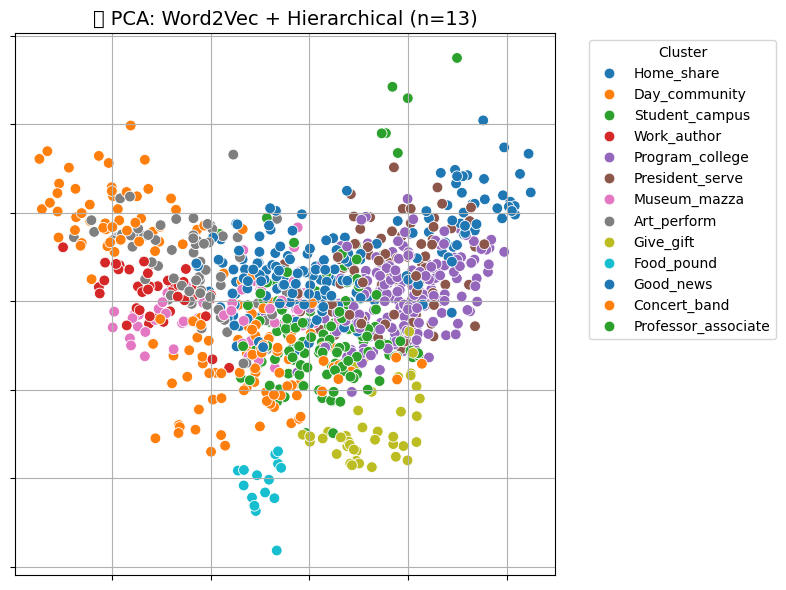

C:\Users\ROHITH\AppData\Local\Temp\ipykernel_20484\2722525300.py:102: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ROHITH\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


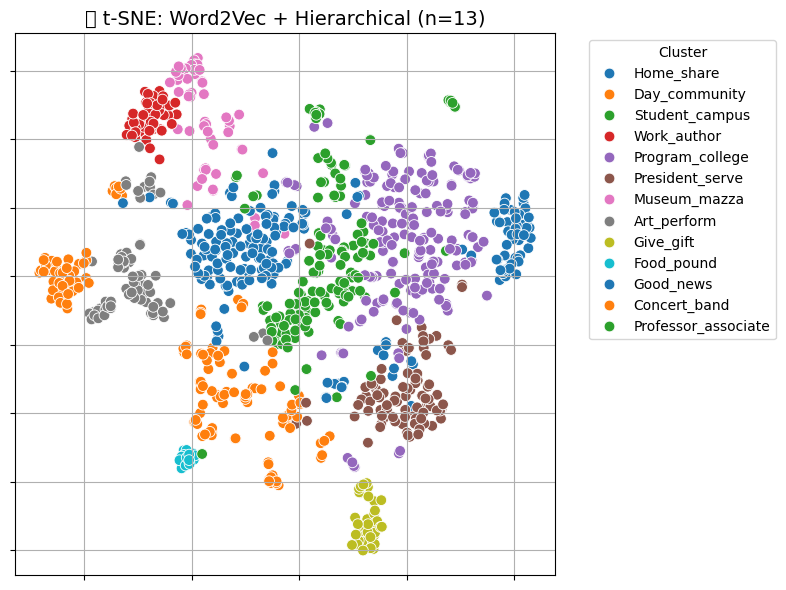

C:\Users\ROHITH\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\ROHITH\AppData\Local\Temp\ipykernel_20484\2722525300.py:102: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ROHITH\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


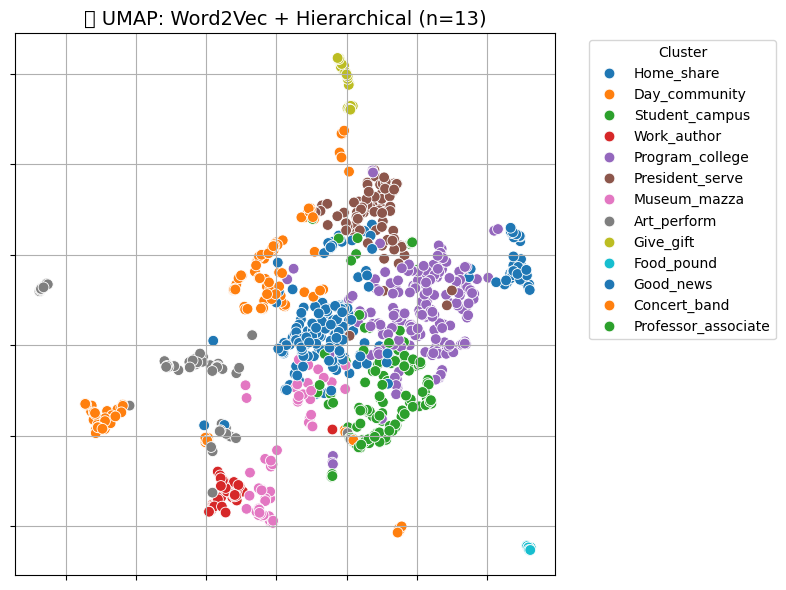

In [156]:
# 🔗 Final clustering using Agglomerative with n = 13
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter

# ✅ Ensure Cleaned_Tokens is a list (convert if string)
if isinstance(df["Cleaned_Tokens"].iloc[0], str):
    df["Cleaned_Tokens"] = df["Cleaned_Tokens"].apply(ast.literal_eval)

# ✅ Run Agglomerative clustering
final_w2v_hier_model = AgglomerativeClustering(n_clusters=13, linkage="ward")
df["Word2Vec_Hier_Cluster"] = final_w2v_hier_model.fit_predict(w2v_hier_doc_vectors)

# 🧠 Get top keywords (10 per cluster)
def get_top_keywords(token_lists, top_n=10):
    all_words = [word for tokens in token_lists for word in tokens if isinstance(tokens, list)]
    most_common = Counter(all_words).most_common(top_n)
    return [word for word, _ in most_common]

# 🔖 Labeling rules (multi-word preferred, no repeats)
def pick_label(keywords, used_labels, used_tokens, cluster_id):
    ignore = {
        "university", "findlay", "uf", "students", "student", "said", "views",
        "shares", "facebook", "tweet", "new", "best", "year", "event"
    }

    # Try bigram → trigram → unigram for clearer, unique labels
    for n in [2, 3, 1]:
        if len(keywords) >= n:
            for i in range(len(keywords) - n + 1):
                candidate = "_".join(keywords[i:i+n])
                candidate_tokens = set(candidate.split("_"))
                if (
                    candidate.lower() not in ignore
                    and candidate not in used_labels
                    and candidate_tokens.isdisjoint(used_tokens)
                ):
                    used_labels.add(candidate)
                    used_tokens |= candidate_tokens
                    return candidate.capitalize()

    # Extended fallback (check beyond top 10)
    if len(keywords) > 10:
        for i in range(10, len(keywords)):
            candidate = keywords[i]
            if (
                candidate.lower() not in ignore
                and candidate not in used_labels
                and candidate not in used_tokens
            ):
                used_labels.add(candidate)
                used_tokens.add(candidate)
                return candidate.capitalize()

    # Final fallback → unique cluster id
    fallback = f"Cluster_{cluster_id}"
    used_labels.add(fallback)
    return fallback

# 🧠 Extract top keywords and assign labels
final_labels = {}
final_keywords = {}
used_labels, used_tokens = set(), set()

for cluster_id in sorted(df["Word2Vec_Hier_Cluster"].unique()):
    group_tokens = df[df["Word2Vec_Hier_Cluster"] == cluster_id]["Cleaned_Tokens"].tolist()
    top_words = get_top_keywords(group_tokens, top_n=10)  # 🔑 now top 10
    final_keywords[cluster_id] = top_words
    final_labels[cluster_id] = pick_label(top_words, used_labels, used_tokens, cluster_id)

# ➕ Assign labels to DataFrame
df["Word2Vec_Hier_Label"] = df["Word2Vec_Hier_Cluster"].map(final_labels)

# ✅ Display summary
print("📌 Final Word2Vec + Hierarchical Labels (n=13):\n")
for cid in sorted(final_labels.keys()):
    print(f"Cluster {cid} → {final_labels[cid]} = {final_keywords[cid]}")

# 📌 Plotting utility (cleaned axes)
def plot_clusters_2D(embedding_2d, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=embedding_2d[:, 0], 
        y=embedding_2d[:, 1], 
        hue=labels, 
        palette="tab10", 
        s=60
    )
    plt.title(title, fontsize=14)
    plt.xlabel("")   # remove axis label
    plt.ylabel("")   # remove axis label
    plt.grid(True)   # keep grid lines
    # Hide tick labels but keep ticks/grid
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# 📊 PCA Projection
X_pca = PCA(n_components=2, random_state=42).fit_transform(w2v_hier_doc_vectors)
plot_clusters_2D(X_pca, df["Word2Vec_Hier_Label"], "📊 PCA: Word2Vec + Hierarchical (n=13)")

# 📊 t-SNE Projection
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(w2v_hier_doc_vectors)
plot_clusters_2D(X_tsne, df["Word2Vec_Hier_Label"], "📊 t-SNE: Word2Vec + Hierarchical (n=13)")

# 📊 UMAP Projection
X_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(w2v_hier_doc_vectors)
plot_clusters_2D(X_umap, df["Word2Vec_Hier_Label"], "📊 UMAP: Word2Vec + Hierarchical (n=13)")


In [158]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Extract predicted cluster labels
final_labels = df["Word2Vec_Hier_Label"].astype("category").cat.codes  # convert to numeric codes

# Compute metrics
sil_score = round(silhouette_score(w2v_hier_doc_vectors, final_labels), 4)
dbi_score = round(davies_bouldin_score(w2v_hier_doc_vectors, final_labels), 4)

print(f"✅ Silhouette Score (n=13): {sil_score}")
print(f"✅ Davies-Bouldin Index (n=13): {dbi_score}")


✅ Silhouette Score (n=13): 0.1276
✅ Davies-Bouldin Index (n=13): 1.7258


###  Save Final Scores (Word2Vec + Hierarchical, n = 13)  
- Create a summary row with **embedding type, clustering method, chosen n, Silhouette Score, and Davies-Bouldin Index**.  
- Append the results to the cumulative scores file (`model_scores_word2vec_kmeans.csv`).  
- Maintain consistency for later comparison across all embedding + clustering models.  


In [161]:
import pandas as pd

# Build row
final_score_row = pd.DataFrame([{
    "Embedding": "Word2Vec",
    "Clustering": "Hierarchical",
    "Best_k": 13,
    "Silhouette_Score": sil_score,
    "Davies_Bouldin_Index": dbi_score
}])

# Append to file
final_score_row.to_csv("model_scores_word2vec_kmeans.csv", mode="a", index=False, header=False)

print("✅ Final scores for Word2Vec + Hierarchical (n=13) appended to 'model_scores_word2vec_kmeans.csv'")


✅ Final scores for Word2Vec + Hierarchical (n=13) appended to 'model_scores_word2vec_kmeans.csv'


###  Embedding (BERT for Hierarchical Clustering)  
- Load the cleaned dataset and join tokens back into full sentences.  
- Use **Sentence Transformers (MiniLM-L6-v2)** to generate BERT embeddings.  
- Cache embeddings to `bert_hier_doc_vectors.npy` for reuse.  
- Load from cache if available to save computation time.  


In [166]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import os

# ✅ Load cleaned dataset
df = pd.read_csv("uf_newsroom_1000_articles_cleaned.csv")

# ✅ Use Cleaned_Text column for BERT (full sentences, minimal preprocessing)
texts_bert = df["Cleaned_Text"].astype(str).tolist()

# ✅ Load pre-trained BERT model (MiniLM)
bert_model = SentenceTransformer("all-MiniLM-L6-v2")

# ✅ Path for cached embeddings
bert_hier_path = "bert_hier_doc_vectors.npy"

# ✅ Load from cache if available, else compute & save
if os.path.exists(bert_hier_path):
    bert_hier_doc_vectors = np.load(bert_hier_path)
    print(f"📂 Loaded cached BERT embeddings. Shape: {bert_hier_doc_vectors.shape}")
else:
    bert_hier_doc_vectors = bert_model.encode(texts_bert, show_progress_bar=True)
    np.save(bert_hier_path, bert_hier_doc_vectors)
    print(f"✅ BERT embeddings generated and saved. Shape: {bert_hier_doc_vectors.shape}")


📂 Loaded cached BERT embeddings. Shape: (1000, 384)


### 📊 Dendrograms (BERT + Hierarchical: n = 2, 7, 14)  
- Constructed the **linkage matrix** using Ward’s method on BERT document vectors.  
- Implemented a function to plot dendrograms with a **distance-based cutoff** corresponding to each target cluster count.  
- Generated **cluster assignments** and extracted the most frequent **top keywords** per cluster for labeling.  
- Visualized truncated dendrograms for **n = 2, 7, and 14 clusters**, each with a red cutoff line.  
- Printed the **top keywords and assigned labels** for each cluster to aid interpretation and topic understanding.  


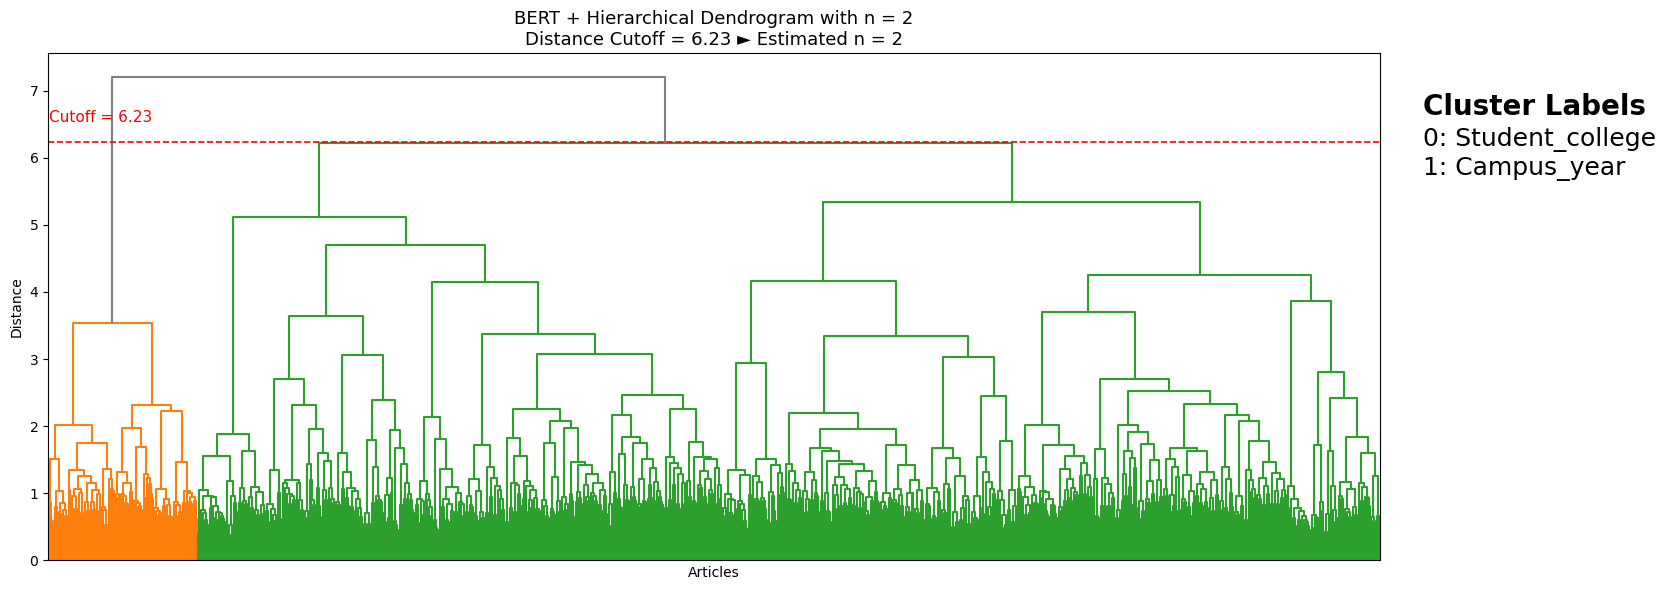


⭐ Top Keywords for n=2:
Cluster 0 → (Student_college) = ['student', 'college', 'event', 'news', 'campus', 'year', 'share', 'home', 'program', 'release']
Cluster 1 → (Campus_year) = ['student', 'program', 'college', 'campus', 'year', 'news', 'event', 'community', 'share', 'home']


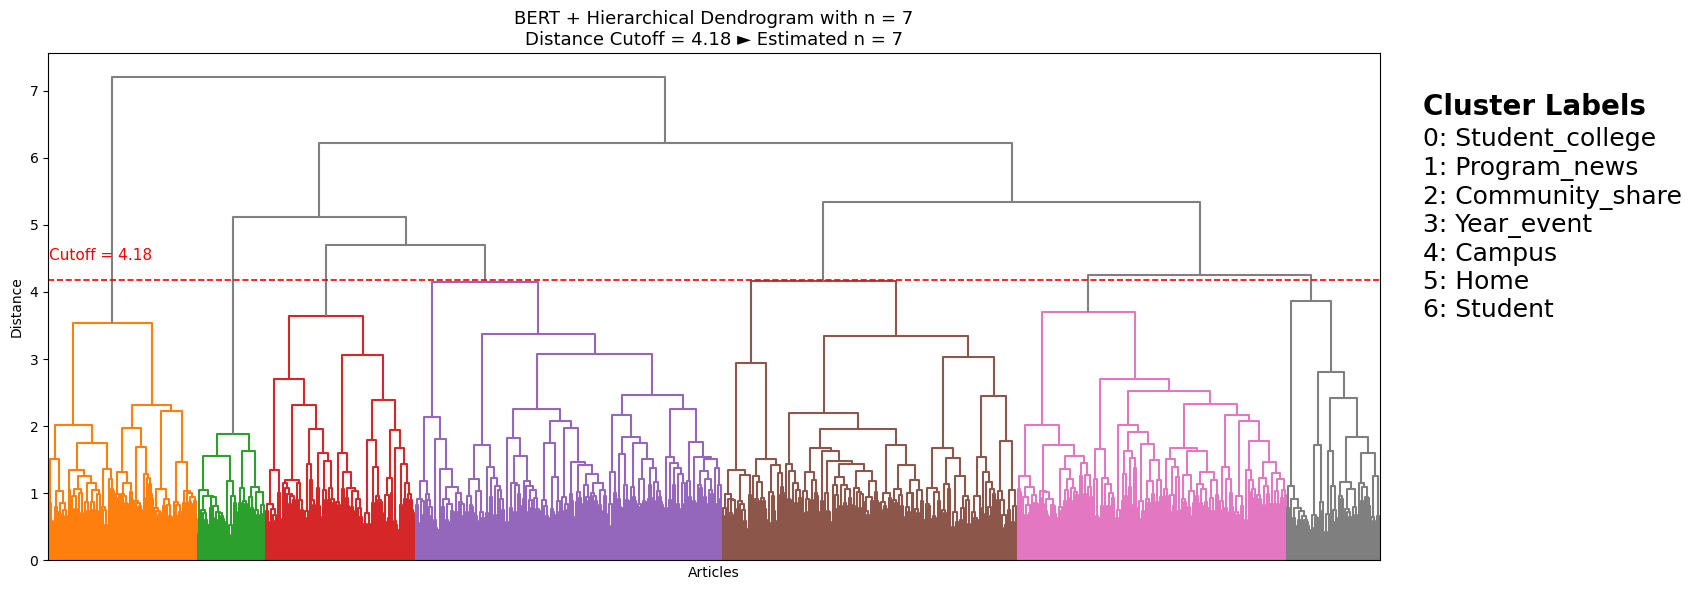


⭐ Top Keywords for n=7:
Cluster 0 → (Student_college) = ['student', 'college', 'event', 'news', 'campus', 'year', 'share', 'home', 'program', 'release']
Cluster 1 → (Program_news) = ['student', 'campus', 'college', 'program', 'news', 'research', 'home', 'event', 'community', 'post']
Cluster 2 → (Community_share) = ['student', 'year', 'program', 'college', 'campus', 'news', 'community', 'share', 'home', 'faculty']
Cluster 3 → (Year_event) = ['student', 'college', 'program', 'campus', 'news', 'year', 'event', 'community', 'share', 'home']
Cluster 4 → (Campus) = ['student', 'program', 'campus', 'event', 'college', 'news', 'year', 'share', 'home', 'community']
Cluster 5 → (Home) = ['student', 'campus', 'program', 'year', 'college', 'news', 'event', 'community', 'share', 'home']
Cluster 6 → (Student) = ['student', 'program', 'year', 'community', 'college', 'news', 'campus', 'home', 'share', 'event']


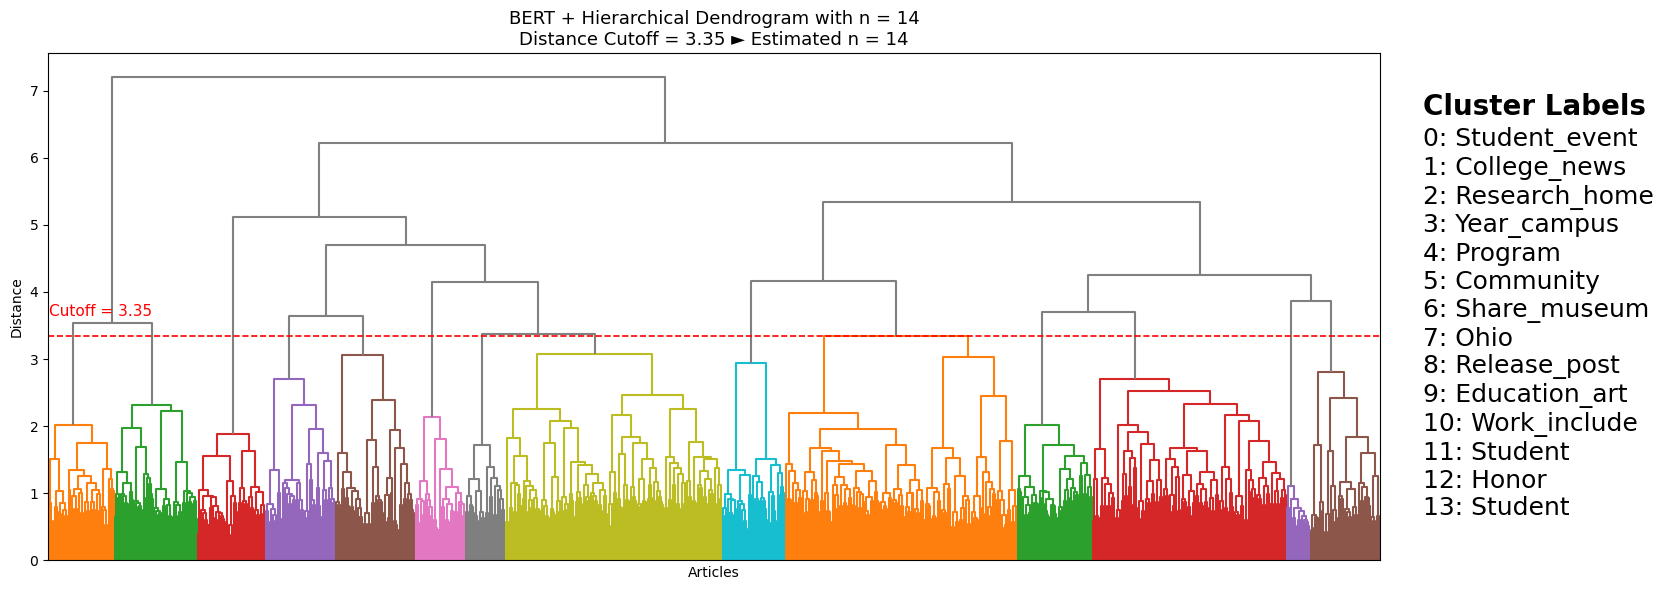


⭐ Top Keywords for n=14:
Cluster 0 → (Student_event) = ['student', 'event', 'campus', 'program', 'share', 'college', 'news', 'year', 'book', 'home']
Cluster 1 → (College_news) = ['student', 'college', 'news', 'year', 'home', 'share', 'event', 'campus', 'work', 'post']
Cluster 2 → (Research_home) = ['student', 'campus', 'college', 'program', 'news', 'research', 'home', 'event', 'community', 'post']
Cluster 3 → (Year_campus) = ['student', 'year', 'campus', 'news', 'college', 'community', 'share', 'home', 'program', 'center']
Cluster 4 → (Program) = ['student', 'program', '_', 'college', 'year', 'news', 'campus', 'pharmacy', 'faculty', 'community']
Cluster 5 → (Community) = ['student', 'year', 'college', 'event', 'campus', 'community', 'program', 'award', 'news', 'share']
Cluster 6 → (Share_museum) = ['student', 'news', 'event', 'campus', 'mazza', 'year', 'share', 'museum', 'college', 'home']
Cluster 7 → (Ohio) = ['student', 'program', 'college', 'campus', 'news', 'community', 'year', 'e

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from collections import Counter
import ast

# --------------------------------------------
# ✅ Load vectors and cleaned tokens
# --------------------------------------------
bert_vectors = np.load("bert_hier_doc_vectors.npy")
df = pd.read_csv("uf_newsroom_1000_articles_cleaned.csv")

# Ensure Cleaned_Tokens is list
if isinstance(df["Cleaned_Tokens"].iloc[0], str):
    df["Cleaned_Tokens"] = df["Cleaned_Tokens"].apply(ast.literal_eval)

token_lists = df["Cleaned_Tokens"].tolist()

# --------------------------------------------
# ✅ Linkage Matrix
# --------------------------------------------
linkage_matrix_bert = linkage(bert_vectors, method="ward")

# --------------------------------------------
# ✅ Labeling rules
# --------------------------------------------
generic_words = {
    "university", "uf", "findlay", "students", "student", "facebook",
    "shares", "tweet", "views", "said", "also", "will",
    "event", "events", "best", "new", "year"
}

def pick_label(keywords, used_labels, used_tokens):
    """Selects a label from keywords, preferring bigrams/trigrams,
    avoids repeats, and never assigns meaningless placeholders."""
    for n in [2, 3, 1]:
        if len(keywords) >= n:
            for i in range(len(keywords) - n + 1):
                candidate = "_".join(keywords[i:i+n]).strip("_")
                candidate_tokens = set(candidate.split("_"))

                if (
                    candidate.lower() not in generic_words
                    and candidate not in used_labels
                    and candidate_tokens.isdisjoint(used_tokens)
                ):
                    used_labels.add(candidate)
                    used_tokens |= candidate_tokens
                    return candidate.capitalize()

    for word in keywords:
        word = word.strip("_")
        if (
            word.lower() not in generic_words
            and word.capitalize() not in used_labels
            and word.lower() not in used_tokens
        ):
            used_labels.add(word.capitalize())
            used_tokens.add(word.lower())
            return word.capitalize()

    if keywords:
        return keywords[0].capitalize()

    return "Unknown"

# --------------------------------------------
# 📊 Plot Dendrogram for a Given n
# --------------------------------------------
def plot_dendrogram_n(linkage_matrix, tokens, desired_n, model_name="BERT + Hierarchical"):
    # Get cutoff threshold for n clusters
    sorted_heights = sorted(linkage_matrix[:, 2], reverse=True)
    cutoff = (
        sorted_heights[desired_n - 1] + 0.01
        if len(sorted_heights) >= desired_n
        else np.percentile(linkage_matrix[:, 2], 90)
    )

    # Assign cluster labels
    labels = fcluster(linkage_matrix, t=cutoff, criterion="distance")
    actual_n = len(set(labels))

    # Extract top 10 keywords and assign labels
    label_keywords = {}
    cluster_labels = {}
    used_labels, used_tokens = set(), set()

    for cid in np.unique(labels):
        cluster_words = [
            word for i, tokens_ in enumerate(tokens) if labels[i] == cid for word in tokens_
        ]
        top_words = [w for w, _ in Counter(cluster_words).most_common(10)]
        label_keywords[cid] = top_words
        cluster_labels[cid] = pick_label(top_words, used_labels, used_tokens)

    # Plot dendrogram
    plt.figure(figsize=(14, 6))
    dendrogram(
        linkage_matrix,
        color_threshold=cutoff,
        above_threshold_color="grey",
        no_labels=True
    )

    # Cutoff line
    plt.axhline(y=cutoff, color="red", linestyle="--", linewidth=1.2)
    plt.text(x=10, y=cutoff + 0.3, s=f"Cutoff = {round(cutoff, 2)}", color="red", fontsize=11)

    # Title and axes
    plt.title(
        f"{model_name} Dendrogram with n = {desired_n}\n"
        f"Distance Cutoff = {round(cutoff, 2)} ► Estimated n = {actual_n}",
        fontsize=13
    )
    plt.xlabel("Articles")
    plt.ylabel("Distance")

    # ✅ Increased legend text size here
    legend_texts = [f"{i}: {cluster_labels[cid]}" for i, cid in enumerate(sorted(cluster_labels.keys()))]
    legend_string = "\n".join(legend_texts)
    plt.gcf().text(1.02, 0.8, "Cluster Labels", fontsize=20, fontweight="bold")  # ↑ increased from 11
    plt.gcf().text(1.02, 0.78, legend_string, fontsize=18, va="top", ha="left")  # ↑ increased from 10

    plt.tight_layout()
    plt.show()

    # Print top 10 keywords per cluster
    print(f"\n⭐ Top Keywords for n={desired_n}:")
    for i, cid in enumerate(sorted(label_keywords.keys())):
        print(f"Cluster {i} → ({cluster_labels[cid]}) = {label_keywords[cid]}")

# --------------------------------------------
# 🔁 Run for n = 2, 7, 14
# --------------------------------------------
plot_dendrogram_n(linkage_matrix_bert, token_lists, desired_n=2)
plot_dendrogram_n(linkage_matrix_bert, token_lists, desired_n=7)
plot_dendrogram_n(linkage_matrix_bert, token_lists, desired_n=14)


In [175]:
from sklearn.cluster import AgglomerativeClustering

# ✅ Final clustering with Agglomerative (n = 14 for BERT Hierarchical)
n_bert_hier_clusters = 14
final_bert_hier = AgglomerativeClustering(n_clusters=n_bert_hier_clusters, linkage="ward")

df["BERT_Hier_Cluster"] = final_bert_hier.fit_predict(bert_hier_doc_vectors)

print(f"✅ Assigned BERT_Hier_Cluster with n = {n_bert_hier_clusters}")


✅ Assigned BERT_Hier_Cluster with n = 14


###  Visualization (BERT + Hierarchical)  
- Define a plotting function for 2D projections.  
- Use **PCA** to show global variance structure in clusters.  
- Apply **t-SNE** to emphasize local neighborhood relationships.  
- Apply **UMAP** for a balance of local and global structure.  
- Plot clusters with assigned labels to compare separation and cohesion across methods.  


📌 Final BERT + Hierarchical Cluster Labels (n = 14):

Cluster 0 → Label: Student_program
   Top Keywords: ['student', 'program', 'college', 'campus', 'event', 'news', 'year', 'home', 'education', 'art']
Cluster 1 → Label: College
   Top Keywords: ['student', 'program', '_', 'college', 'year', 'news', 'campus', 'pharmacy', 'faculty', 'community']
Cluster 2 → Label: Campus_news
   Top Keywords: ['student', 'program', 'college', 'campus', 'news', 'community', 'year', 'event', 'share', 'ohio']
Cluster 3 → Label: Year_home
   Top Keywords: ['student', 'event', 'campus', 'news', 'share', 'program', 'year', 'home', 'release', 'post']
Cluster 4 → Label: Work_include
   Top Keywords: ['student', 'program', 'college', 'campus', 'news', 'community', 'year', 'home', 'work', 'include']
Cluster 5 → Label: Share_event
   Top Keywords: ['student', 'year', 'program', 'community', 'college', 'campus', 'news', 'home', 'share', 'event']
Cluster 6 → Label: Community
   Top Keywords: ['student', 'campus', '

C:\Users\ROHITH\AppData\Local\Temp\ipykernel_20484\3841078912.py:107: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ROHITH\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


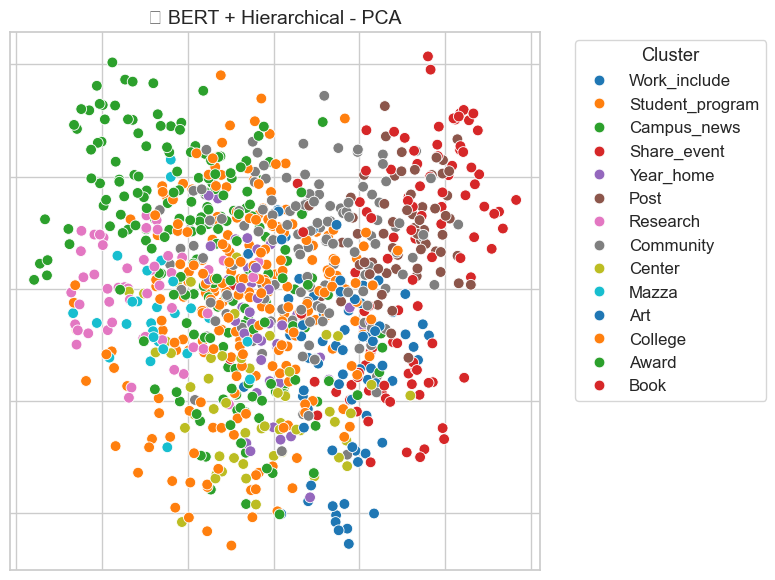

C:\Users\ROHITH\AppData\Local\Temp\ipykernel_20484\3841078912.py:107: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ROHITH\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


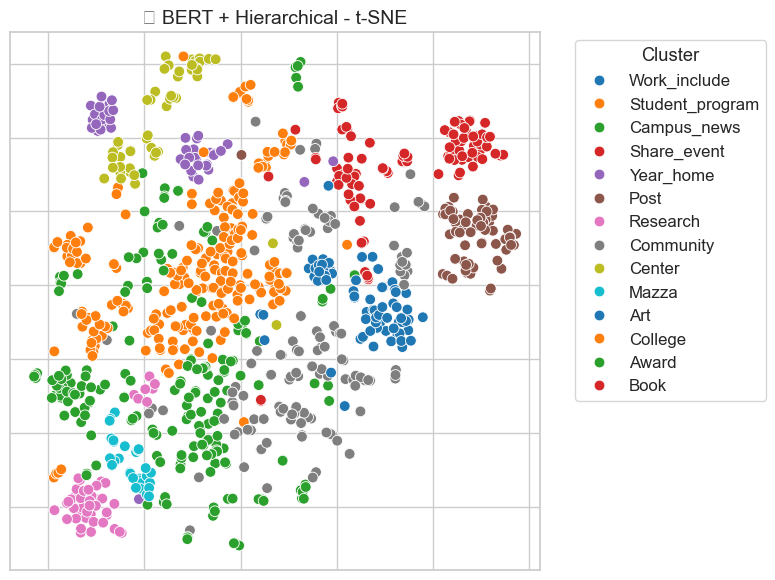

C:\Users\ROHITH\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\ROHITH\AppData\Local\Temp\ipykernel_20484\3841078912.py:107: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ROHITH\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


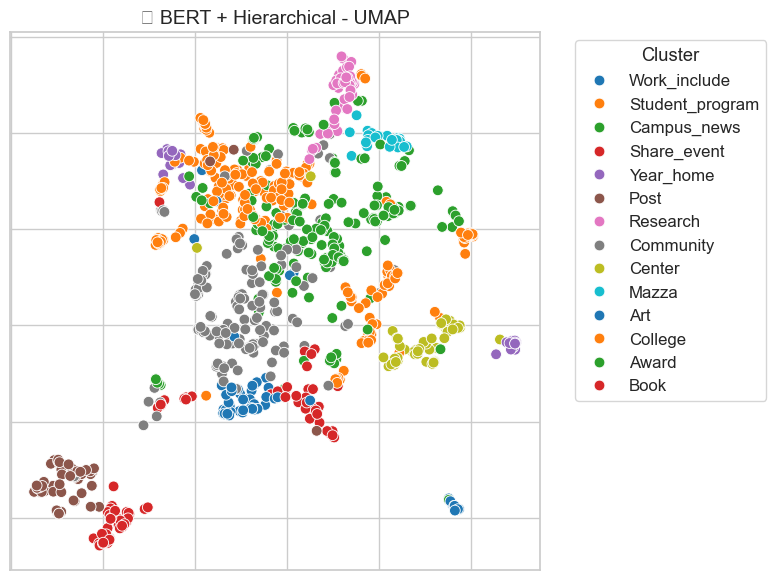

In [178]:
import ast
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
# ✅ Step 1: Convert stringified tokens to lists
# ------------------------------------------------
if isinstance(df["Cleaned_Tokens"].iloc[0], str):
    df["Cleaned_Tokens"] = df["Cleaned_Tokens"].apply(ast.literal_eval)

# ------------------------------------------------
# ✅ Step 2: Define generic (useless) words
# ------------------------------------------------
generic_words = {
    "university", "uf", "findlay", "students", "student", "facebook", "shares", 
    "tweet", "views", "said", "also", "will", "event", "events", "best", "new", "year"
}

# ------------------------------------------------
# ✅ Step 3: Labeling rules (phrases preferred, no repeats, no placeholders)
# ------------------------------------------------
def pick_label(keywords, used_labels, used_tokens):
    # Prefer bigram → trigram → unigram
    for n in [2, 3, 1]:
        if len(keywords) >= n:
            for i in range(len(keywords) - n + 1):
                candidate = "_".join(keywords[i:i+n]).strip("_")
                candidate_tokens = set(candidate.split("_"))
                if (
                    candidate.lower() not in generic_words
                    and candidate not in used_labels
                    and candidate_tokens.isdisjoint(used_tokens)
                ):
                    used_labels.add(candidate)
                    used_tokens |= candidate_tokens
                    return candidate.capitalize()

    # Fallback → pick any other unused keyword
    for word in keywords:
        word = word.strip("_")
        if (
            word.lower() not in generic_words
            and word.capitalize() not in used_labels
            and word.lower() not in used_tokens
        ):
            used_labels.add(word.capitalize())
            used_tokens.add(word.lower())
            return word.capitalize()

    # Last resort → return first keyword (always a real word)
    if keywords:
        return keywords[0].capitalize()

    return "Unknown"

# ------------------------------------------------
# ✅ Step 4: Assign labels + top keywords
# ------------------------------------------------
bert_hier_labels = {}
bert_hier_keywords = {}
used_labels, used_tokens = set(), set()

for cid in sorted(df["BERT_Hier_Cluster"].unique()):
    token_lists = df[df["BERT_Hier_Cluster"] == cid]["Cleaned_Tokens"]
    all_words = [word for tokens in token_lists for word in tokens]
    common_words = [word for word, _ in Counter(all_words).most_common(10)]
    bert_hier_keywords[cid] = common_words  # store top 10 words
    bert_hier_labels[cid] = pick_label(common_words, used_labels, used_tokens)

# ➕ Assign labels to DataFrame
df["BERT_Hier_Label"] = df["BERT_Hier_Cluster"].map(bert_hier_labels)

# ------------------------------------------------
# ✅ Step 5: Print results
# ------------------------------------------------
print(f"📌 Final BERT + Hierarchical Cluster Labels (n = {n_bert_hier_clusters}):\n")
for cid, label in bert_hier_labels.items():
    print(f"Cluster {cid} → Label: {label}")
    print(f"   Top Keywords: {bert_hier_keywords[cid]}")

# ------------------------------------------------
# ✅ Step 6: 2D Visualizations (PCA, t-SNE, UMAP)
# ------------------------------------------------
sns.set(style="whitegrid", font_scale=1.1)

def plot_2d_projection(data_2d, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=data_2d[:, 0], 
        y=data_2d[:, 1], 
        hue=labels, 
        palette="tab10", 
        s=60
    )
    plt.title(title, fontsize=14)
    plt.xlabel("")   # remove axis label
    plt.ylabel("")   # remove axis label
    plt.grid(True)   # keep grid lines
    # Hide tick labels but keep ticks/grid
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# 📊 PCA Projection
pca_proj = PCA(n_components=2, random_state=42).fit_transform(bert_hier_doc_vectors)
plot_2d_projection(pca_proj, df["BERT_Hier_Label"], "📊 BERT + Hierarchical - PCA")

# 📊 t-SNE Projection
tsne_proj = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(bert_hier_doc_vectors)
plot_2d_projection(tsne_proj, df["BERT_Hier_Label"], "📊 BERT + Hierarchical - t-SNE")

# 📊 UMAP Projection
umap_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(bert_hier_doc_vectors)
plot_2d_projection(umap_proj, df["BERT_Hier_Label"], "📊 BERT + Hierarchical - UMAP")


###  Save Final Scores (BERT + Hierarchical, n = 12)  
- Compute **Silhouette Score** and **Davies-Bouldin Index** for the selected cluster solution (n = 12).  
- Store results in a summary DataFrame with embedding, clustering method, and chosen n.  
- Append scores to the cumulative results file (`model_scores_word2vec_kmeans.csv`).  
- Maintain consistency across all models for final comparison.  


In [181]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd

# Compute scores
sil_bert_hier = round(silhouette_score(bert_hier_doc_vectors, df["BERT_Hier_Cluster"]), 4)
dbi_bert_hier = round(davies_bouldin_score(bert_hier_doc_vectors, df["BERT_Hier_Cluster"]), 4)

# Prepare row
bert_hier_score_row = pd.DataFrame([{
    "Embedding": "BERT",
    "Clustering": "Hierarchical",
    "Best_k": 12,  # Selected manually
    "Silhouette_Score": sil_bert_hier,
    "Davies_Bouldin_Index": dbi_bert_hier
}])

# Append to main score file
bert_hier_score_row.to_csv("model_scores_word2vec_kmeans.csv", mode="a", index=False, header=False)

# ✅ Output summary
print("✅ Appended BERT + Hierarchical (n=12) scores to evaluation file.")
bert_hier_score_row


✅ Appended BERT + Hierarchical (n=12) scores to evaluation file.


Embedding    Clustering  Best_k  Silhouette_Score  Davies_Bouldin_Index
0      BERT  Hierarchical      12             0.051                3.2127

###  Embedding (GloVe for Hierarchical Clustering)  
- Load the cleaned dataset of articles.  
- Load the pretrained **GloVe embeddings (100d)**.  
- Convert each article into a document vector by averaging its token embeddings.  
- Save the final **GloVe document vector matrix** to `glove_hier_doc_vectors.npy` for reuse.  


In [185]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import ast

# ✅ Load cleaned dataset
df = pd.read_csv("uf_newsroom_1000_articles_cleaned.csv")

# ✅ Ensure Cleaned_Tokens is a list (convert if stringified)
if isinstance(df["Cleaned_Tokens"].iloc[0], str):
    df["Cleaned_Tokens"] = df["Cleaned_Tokens"].apply(ast.literal_eval)

# ✅ Load GloVe model (converted to word2vec format)
glove_model = KeyedVectors.load_word2vec_format("glove.6B.100d.word2vec.txt", binary=False)

# ✅ Convert tokens into GloVe document vectors
def get_glove_vector(tokens, model, vector_size=100):
    vectors = [model[word] for word in tokens if word in model]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

# ✅ Generate vectors for all articles
token_lists_glove = df["Cleaned_Tokens"].tolist()
glove_hier_doc_vectors = np.array([get_glove_vector(tokens, glove_model) for tokens in token_lists_glove])

# ✅ Save vectors for later steps
np.save("glove_hier_doc_vectors.npy", glove_hier_doc_vectors)
print(f"✅ GloVe document vectors created. Shape: {glove_hier_doc_vectors.shape}")


✅ GloVe document vectors created. Shape: (1000, 100)


###  Dendrograms (GloVe + Hierarchical, n = 2, 6, 12)  
- Load the **GloVe document vectors** and cleaned tokens.  
- Build a **linkage matrix** using Ward’s method.  
- Define a function to plot dendrograms with a **distance cutoff** for a chosen n.  
- Assign cluster labels and extract **top keywords** for each cluster.  
- Plot dendrograms for **n = 2, 6, and 12** clusters with cutoff lines.  
- Print top keywords for each cluster to support interpretation.  


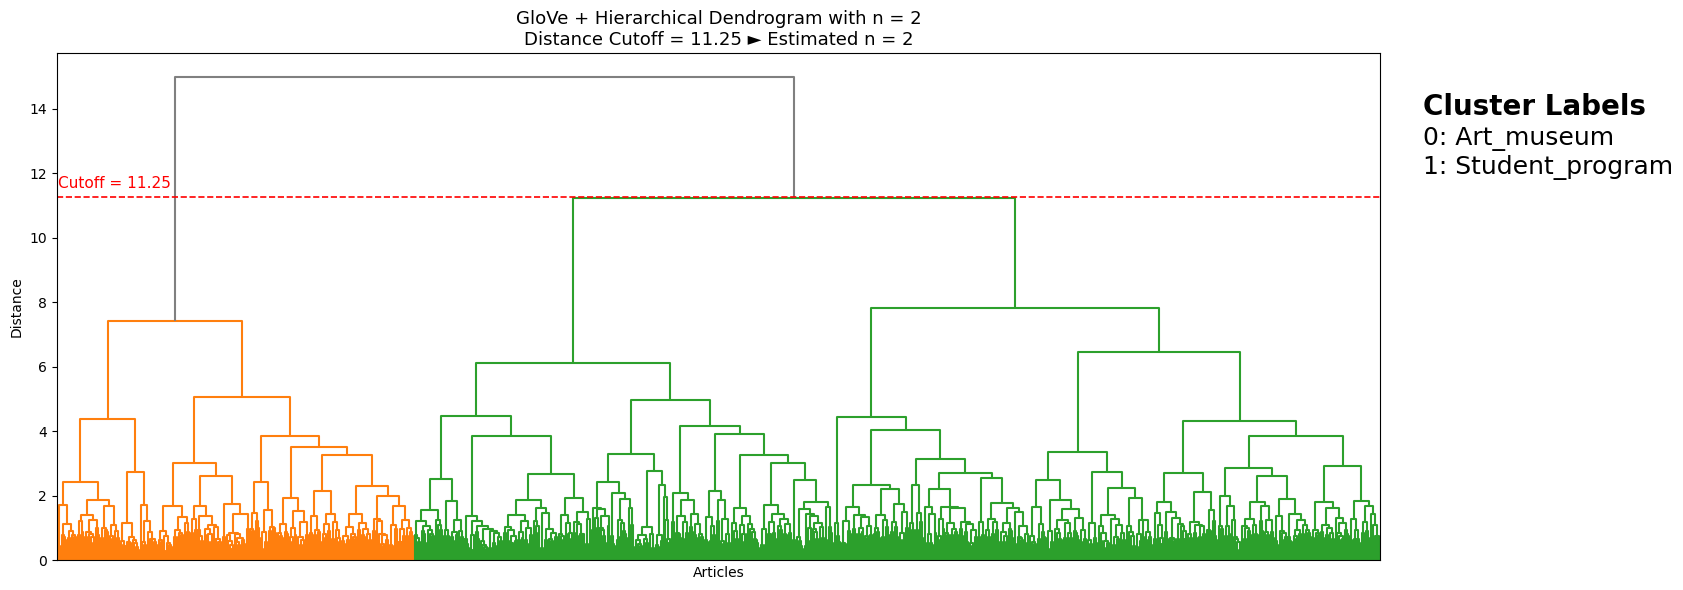


⭐ Top Keywords for n=2:
Cluster 0 → (Art_museum) = ['art', 'museum', 'mazza', 'event', 'student', 'perform', 'book', 'news', 'share', 'include']
Cluster 1 → (Student_program) = ['student', 'program', 'college', 'campus', 'year', 'news', 'community', 'event', 'share', 'home']


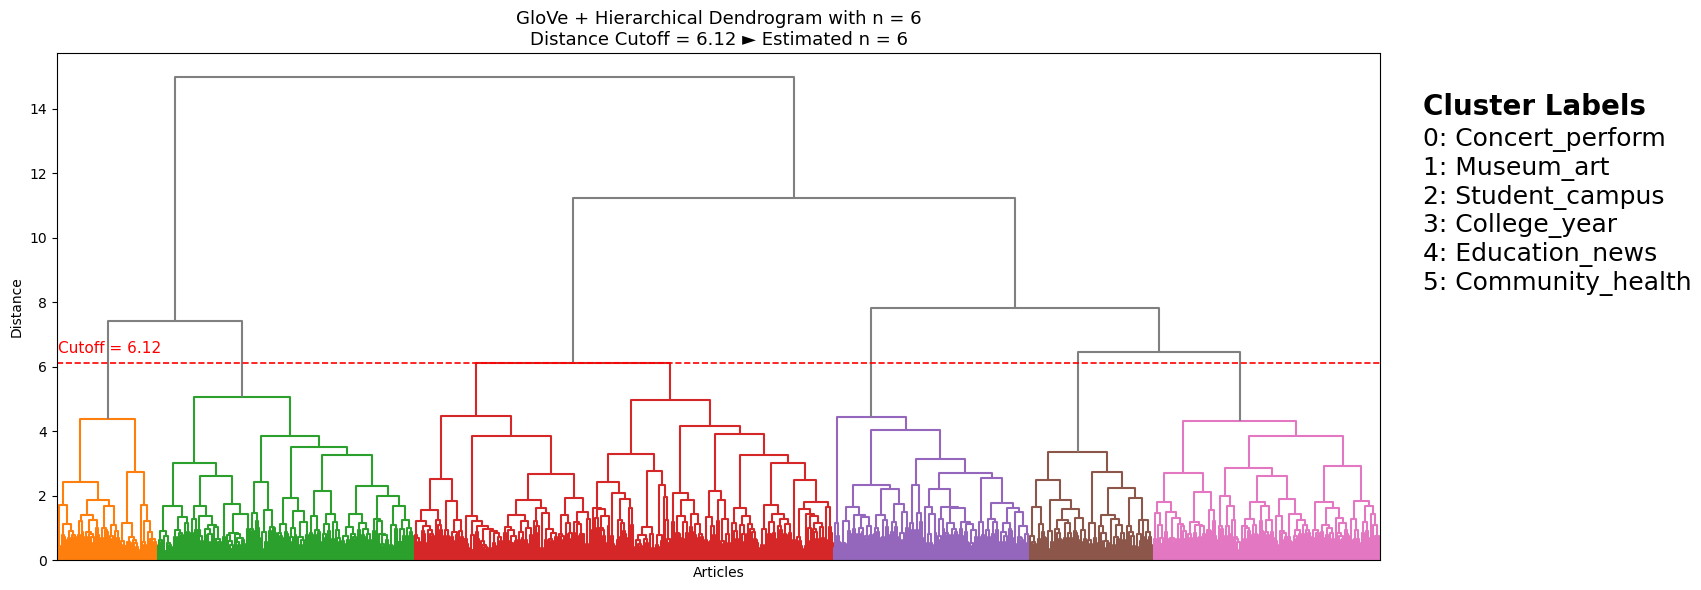


⭐ Top Keywords for n=6:
Cluster 0 → (Concert_perform) = ['concert', 'perform', 'art', 'broadway', 'music', 'student', 'event', 'band', 'ticket', 'center']
Cluster 1 → (Museum_art) = ['museum', 'art', 'mazza', 'book', 'event', 'student', 'news', 'feature', 'share', 'work']
Cluster 2 → (Student_campus) = ['student', 'campus', 'year', 'event', 'news', 'community', 'home', 'share', 'day', 'help']
Cluster 3 → (College_year) = ['student', 'college', 'year', 'award', 'professor', 'program', 'serve', 'business', 'faculty', 'news']
Cluster 4 → (Education_news) = ['program', 'student', 'college', 'education', 'news', 'school', 'pharmacy', 'good', 'degree', 'year']
Cluster 5 → (Community_health) = ['student', 'program', 'campus', 'community', 'health', 'news', 'college', 'ohio', 'work', 'share']


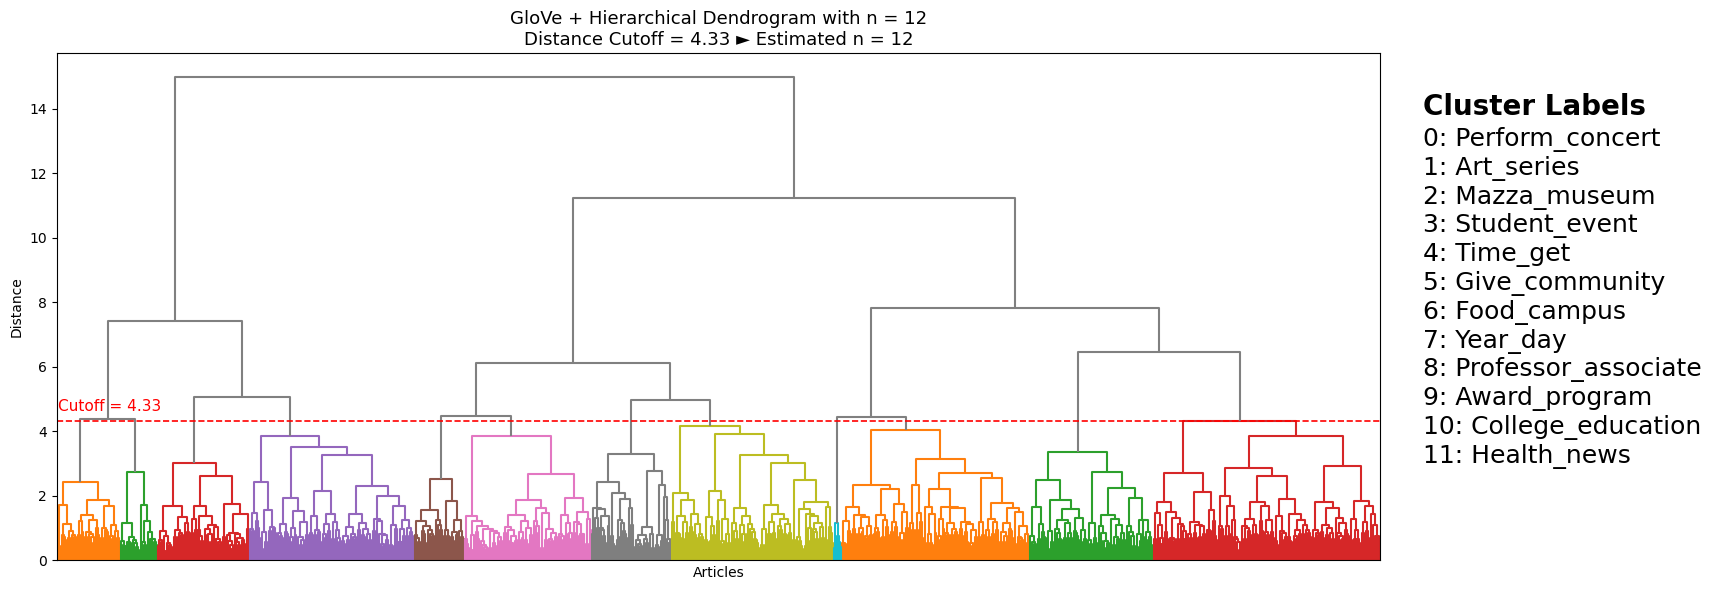


⭐ Top Keywords for n=12:
Cluster 0 → (Perform_concert) = ['perform', 'concert', 'art', 'band', 'music', 'event', 'release', 'home', 'share', 'ticket']
Cluster 1 → (Art_series) = ['broadway', 'concert', 'perform', 'art', 'series', 'theatre', 'student', 'donnell', 'award', 'stage']
Cluster 2 → (Mazza_museum) = ['mazza', 'museum', 'book', 'artist', 'feature', 'art', 'event', 'author', 'include', 'work']
Cluster 3 → (Student_event) = ['art', 'student', 'event', 'campus', 'center', 'share', 'community', 'news', 'year', 'home']
Cluster 4 → (Time_get) = ['time', 'get', 'year', 'take', 'student', 'make', 'work', 'day', 'home', 'start']
Cluster 5 → (Give_community) = ['student', 'give', 'community', 'campus', 'year', 'news', 'program', 'research', 'event', 'make']
Cluster 6 → (Food_campus) = ['student', 'food', 'campus', 'year', '_', 'help', 'event', 'pound', 'drive', 'news']
Cluster 7 → (Year_day) = ['student', 'campus', 'event', 'year', 'day', 'news', 'community', 'program', 'college', 'home

In [15]:
# 📦 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from collections import Counter
import ast

# --------------------------------------------
# ✅ Load vectors and cleaned tokens
# --------------------------------------------
glove_vectors = np.load("glove_hier_doc_vectors.npy")
df = pd.read_csv("uf_newsroom_1000_articles_cleaned.csv")

# Ensure Cleaned_Tokens is list
if isinstance(df["Cleaned_Tokens"].iloc[0], str):
    df["Cleaned_Tokens"] = df["Cleaned_Tokens"].apply(ast.literal_eval)

token_lists = df["Cleaned_Tokens"].tolist()

# --------------------------------------------
# ✅ Linkage Matrix
# --------------------------------------------
linkage_matrix_glove = linkage(glove_vectors, method="ward")

# --------------------------------------------
# ✅ Labeling rules (multi-word priority, no repeats)
# --------------------------------------------
generic_words = {
    "university", "uf", "findlay", "students", "student", "facebook", "shares", 
    "tweet", "views", "said", "also", "will", "event", "events", "best", "new", "year", "get"
}

def pick_label(keywords, used_labels, used_tokens):
    """Prefers multi-word labels and avoids duplicates/generic words."""
    for n in [2, 3, 1]:
        if len(keywords) >= n:
            for i in range(len(keywords) - n + 1):
                candidate = "_".join(keywords[i:i+n]).strip("_")
                candidate_tokens = set(candidate.split("_"))
                if (
                    candidate.lower() not in generic_words
                    and candidate not in used_labels
                    and candidate_tokens.isdisjoint(used_tokens)
                ):
                    used_labels.add(candidate)
                    used_tokens |= candidate_tokens
                    return candidate.capitalize()

    for word in keywords:
        word = word.strip("_")
        if (
            word.lower() not in generic_words
            and word.capitalize() not in used_labels
            and word.lower() not in used_tokens
        ):
            used_labels.add(word.capitalize())
            used_tokens.add(word.lower())
            return word.capitalize()

    if keywords:
        return keywords[0].capitalize()
    return "Unknown"

# --------------------------------------------
# 📊 Plot Dendrogram for a Given n
# --------------------------------------------
def plot_dendrogram_n(linkage_matrix, tokens, desired_n, model_name="GloVe + Hierarchical"):
    # Auto-select cutoff for n clusters
    sorted_heights = sorted(linkage_matrix[:, 2], reverse=True)
    cutoff = (
        sorted_heights[desired_n - 1] + 0.01
        if len(sorted_heights) >= desired_n
        else np.percentile(linkage_matrix[:, 2], 90)
    )

    # Assign cluster labels
    labels = fcluster(linkage_matrix, t=cutoff, criterion="distance")
    actual_n = len(set(labels))

    # Extract top 10 keywords per cluster
    label_keywords = {}
    cluster_labels = {}
    used_labels, used_tokens = set(), set()

    for cid in np.unique(labels):
        cluster_words = [
            word for i, tokens_ in enumerate(tokens) if labels[i] == cid for word in tokens_
        ]
        top_words = [w for w, _ in Counter(cluster_words).most_common(10)]
        label_keywords[cid] = top_words
        cluster_labels[cid] = pick_label(top_words, used_labels, used_tokens)

    # --------------------------------------------
    # 📈 Plot dendrogram (standardized to BERT/W2V style)
    # --------------------------------------------
    plt.figure(figsize=(14, 6))
    dendrogram(
        linkage_matrix,
        color_threshold=cutoff,
        above_threshold_color="grey",
        no_labels=True
    )

    # Cutoff line
    plt.axhline(y=cutoff, color="red", linestyle="--", linewidth=1.2)
    plt.text(x=10, y=cutoff + 0.3, s=f"Cutoff = {round(cutoff, 2)}", color="red", fontsize=11)

    # Title and axis labels
    plt.title(
        f"{model_name} Dendrogram with n = {desired_n}\n"
        f"Distance Cutoff = {round(cutoff, 2)} ► Estimated n = {actual_n}",
        fontsize=13
    )
    plt.xlabel("Articles")
    plt.ylabel("Distance")

    # ✅ Legend on the right side (same as BERT/W2V)
    legend_texts = [f"{i}: {cluster_labels[cid]}" for i, cid in enumerate(sorted(cluster_labels.keys()))]
    legend_string = "\n".join(legend_texts)
    plt.gcf().text(1.02, 0.8, "Cluster Labels", fontsize=20, fontweight="bold")  # header
    plt.gcf().text(1.02, 0.78, legend_string, fontsize=18, va="top", ha="left")  # content

    plt.tight_layout()
    plt.show()

    # ✅ Print top 10 keywords underneath each respective plot
    print(f"\n⭐ Top Keywords for n={desired_n}:")
    for i, cid in enumerate(sorted(label_keywords.keys())):
        print(f"Cluster {i} → ({cluster_labels[cid]}) = {label_keywords[cid]}")

# --------------------------------------------
# 🔁 Run for 3 values: n = 2, 6, 12
# --------------------------------------------
plot_dendrogram_n(linkage_matrix_glove, token_lists, desired_n=2)
plot_dendrogram_n(linkage_matrix_glove, token_lists, desired_n=6)
plot_dendrogram_n(linkage_matrix_glove, token_lists, desired_n=12)


###  Visualization (GloVe + Hierarchical, n = 12)  
- Define a helper function to plot 2D projections of clusters.  
- Apply **PCA** for variance-based global structure visualization.  
- Apply **t-SNE** to highlight local neighborhood relationships.  
- Apply **UMAP** for balanced local and global structure preservation.  
- Plot scatter visualizations with cluster labels for interpretation.  


📌 Final GloVe + Hierarchical Labels (n=12):

Cluster 0 → Student_program = ['student', 'program', 'campus', 'community', 'health', 'news', 'college', 'ohio', 'work', 'share']
Cluster 1 → College_year = ['student', 'college', 'year', 'award', 'program', 'serve', 'business', 'news', 'faculty', 'member']
Cluster 2 → Campus_event = ['student', 'campus', 'event', 'year', 'day', 'news', 'community', 'program', 'college', 'home']
Cluster 3 → Center_share = ['art', 'student', 'event', 'campus', 'center', 'share', 'community', 'news', 'year', 'home']
Cluster 4 → Give_community = ['student', 'give', 'community', 'campus', 'year', 'news', 'program', 'research', 'event', 'make']
Cluster 5 → Education_news = ['program', 'student', 'college', 'education', 'news', 'school', 'pharmacy', 'good', 'degree', 'year']
Cluster 6 → Broadway_concert = ['broadway', 'concert', 'perform', 'art', 'series', 'theatre', 'student', 'donnell', 'award', 'stage']
Cluster 7 → Mazza_museum = ['mazza', 'museum', 'book', 'ar

C:\Users\ROHITH\AppData\Local\Temp\ipykernel_20484\3119471623.py:128: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ROHITH\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


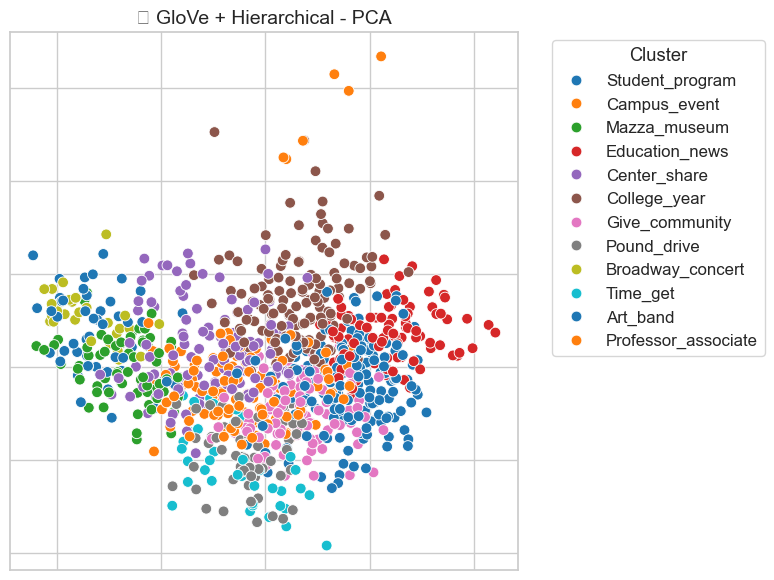

C:\Users\ROHITH\AppData\Local\Temp\ipykernel_20484\3119471623.py:128: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ROHITH\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


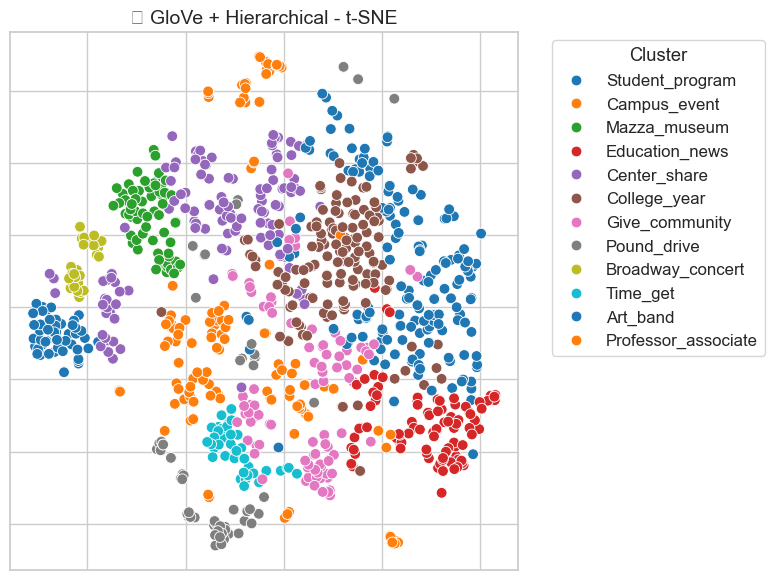

C:\Users\ROHITH\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\ROHITH\AppData\Local\Temp\ipykernel_20484\3119471623.py:128: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ROHITH\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


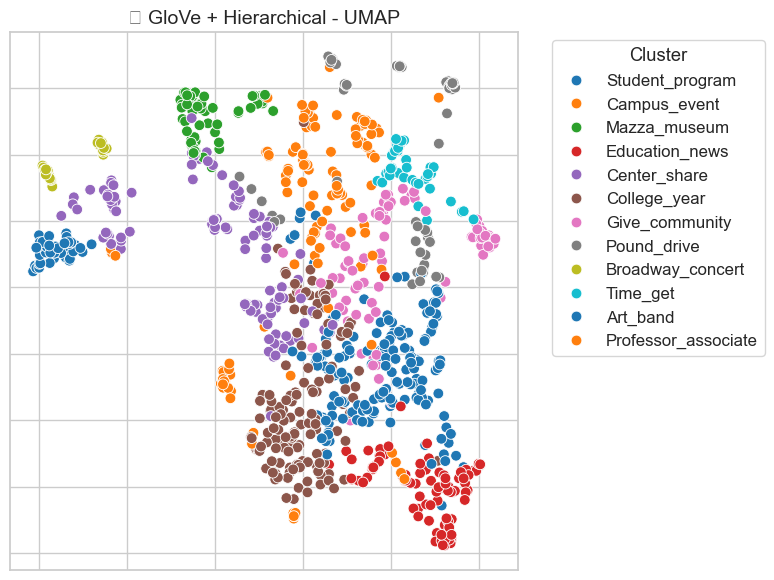

In [197]:
import numpy as np
import pandas as pd
import ast
from collections import Counter
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------
# ✅ Load vectors and cleaned data
# ------------------------------------------------
glove_vectors = np.load("glove_hier_doc_vectors.npy")
df = pd.read_csv("uf_newsroom_1000_articles_cleaned.csv")

# Ensure Cleaned_Tokens is list
if isinstance(df["Cleaned_Tokens"].iloc[0], str):
    df["Cleaned_Tokens"] = df["Cleaned_Tokens"].apply(ast.literal_eval)

token_lists_glove = df["Cleaned_Tokens"].tolist()

# ------------------------------------------------
# 🧠 Helper: Extract top keywords
# ------------------------------------------------
def get_top_keywords(token_lists, top_n=10):
    all_tokens = [word for tokens in token_lists for word in tokens if word.isalpha()]
    return [w for w, _ in Counter(all_tokens).most_common(top_n)]

# ------------------------------------------------
# 🚫 Generic words
# ------------------------------------------------
generic_words = {
    "university", "findlay", "uf", "student", "students", "campus", "year",
    "facebook", "shares", "tweet", "views", "said", "also", "will", 
    "event", "events", "best", "new"
}

# ------------------------------------------------
# 🏷️ Labeling rules
# ------------------------------------------------
def pick_label(keywords, used_labels, used_tokens):
    # Prefer bigram → trigram → unigram
    for n in [2, 3, 1]:
        if len(keywords) >= n:
            for i in range(len(keywords) - n + 1):
                candidate = "_".join(keywords[i:i+n]).strip("_")
                candidate_tokens = set(candidate.split("_"))
                if (
                    candidate.lower() not in generic_words
                    and candidate not in used_labels
                    and candidate_tokens.isdisjoint(used_tokens)
                ):
                    used_labels.add(candidate)
                    used_tokens |= candidate_tokens
                    return candidate.capitalize()

    # Fallback → pick another unused keyword
    for word in keywords:
        word = word.strip("_")
        if (
            word.lower() not in generic_words
            and word.capitalize() not in used_labels
            and word.lower() not in used_tokens
        ):
            used_labels.add(word.capitalize())
            used_tokens.add(word.lower())
            return word.capitalize()

    # Last resort → return first keyword (always real word)
    if keywords:
        return keywords[0].capitalize()

    return "Unknown"

# ------------------------------------------------
# 🔗 Agglomerative Clustering
# ------------------------------------------------
final_glove_hier_model = AgglomerativeClustering(n_clusters=12, linkage="ward")
df["GloVe_Hier_Cluster"] = final_glove_hier_model.fit_predict(glove_vectors)

# ------------------------------------------------
# 🧠 Extract keywords and assign labels
# ------------------------------------------------
final_labels_glove = {}
final_keywords_glove = {}
used_labels, used_tokens = set(), set()

for cluster_id in sorted(df["GloVe_Hier_Cluster"].unique()):
    group_tokens = [tokens for i, tokens in enumerate(token_lists_glove) if df["GloVe_Hier_Cluster"].iloc[i] == cluster_id]
    top_words = get_top_keywords(group_tokens, top_n=10)  # ✅ now top 10
    final_keywords_glove[cluster_id] = top_words
    final_labels_glove[cluster_id] = pick_label(top_words, used_labels, used_tokens)

# Assign labels back to DataFrame
df["GloVe_Hier_Label"] = df["GloVe_Hier_Cluster"].map(final_labels_glove)

# ------------------------------------------------
# ✅ Display summary
# ------------------------------------------------
print("📌 Final GloVe + Hierarchical Labels (n=12):\n")
for cid in sorted(final_labels_glove.keys()):
    print(f"Cluster {cid} → {final_labels_glove[cid]} = {final_keywords_glove[cid]}")

# ------------------------------------------------
# 📊 2D Visualizations (PCA, t-SNE, UMAP)
# ------------------------------------------------
sns.set(style="whitegrid", font_scale=1.1)

def plot_2d_projection(data_2d, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=data_2d[:, 0], 
        y=data_2d[:, 1], 
        hue=labels, 
        palette="tab10", 
        s=60
    )
    plt.title(title, fontsize=14)
    plt.xlabel("")
    plt.ylabel("")
    plt.grid(True)
    # Hide tick labels but keep ticks/grid
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# PCA
pca_proj = PCA(n_components=2, random_state=42).fit_transform(glove_vectors)
plot_2d_projection(pca_proj, df["GloVe_Hier_Label"], "📊 GloVe + Hierarchical - PCA")

# t-SNE
tsne_proj = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(glove_vectors)
plot_2d_projection(tsne_proj, df["GloVe_Hier_Label"], "📊 GloVe + Hierarchical - t-SNE")

# UMAP
umap_proj = umap.UMAP(n_components=2, random_state=42).fit_transform(glove_vectors)
plot_2d_projection(umap_proj, df["GloVe_Hier_Label"], "📊 GloVe + Hierarchical - UMAP")


###  Save Final Scores (GloVe + Hierarchical, n = 12)  
- Compute **Silhouette Score** and **Davies-Bouldin Index** for the final clustering (n = 12).  
- Store results in a summary DataFrame with embedding type, method, and scores.  
- Append the results to the cumulative file (`model_scores_word2vec_kmeans.csv`).  
- Ensure consistency across all models for later comparison.  


In [200]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd

# Compute scores
sil_glove_hier = round(silhouette_score(glove_hier_doc_vectors, df["GloVe_Hier_Cluster"]), 4)
dbi_glove_hier = round(davies_bouldin_score(glove_hier_doc_vectors, df["GloVe_Hier_Cluster"]), 4)

# Prepare row
glove_hier_score_row = pd.DataFrame([{
    "Embedding": "GloVe",
    "Clustering": "Hierarchical",
    "Best_k": 12,  # Selected manually
    "Silhouette_Score": sil_glove_hier,
    "Davies_Bouldin_Index": dbi_glove_hier
}])

# Append to main score file
glove_hier_score_row.to_csv("model_scores_word2vec_kmeans.csv", mode="a", index=False, header=False)

# ✅ Output summary
print("✅ Appended GloVe + Hierarchical (n=12) scores to evaluation file.")
glove_hier_score_row


✅ Appended GloVe + Hierarchical (n=12) scores to evaluation file.


Embedding    Clustering  Best_k  Silhouette_Score  Davies_Bouldin_Index
0     GloVe  Hierarchical      12              0.06                2.4294

###  Final Model Comparison (All Embeddings + Clustering Methods)  
- Load the consolidated results file with all models’ scores.  
- Combine **embedding type** and **clustering method** into a single model label.  
- Plot a scatter chart of **Silhouette Score vs Davies-Bouldin Index**.  
- Annotate each point with the corresponding model name.  
- Compare models:  
  - **Higher Silhouette Score** = better-defined clusters.  
  - **Lower DBI** = stronger separation between clusters.  


C:\Users\ROHITH\AppData\Local\Temp\ipykernel_20484\389197350.py:34: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\ROHITH\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


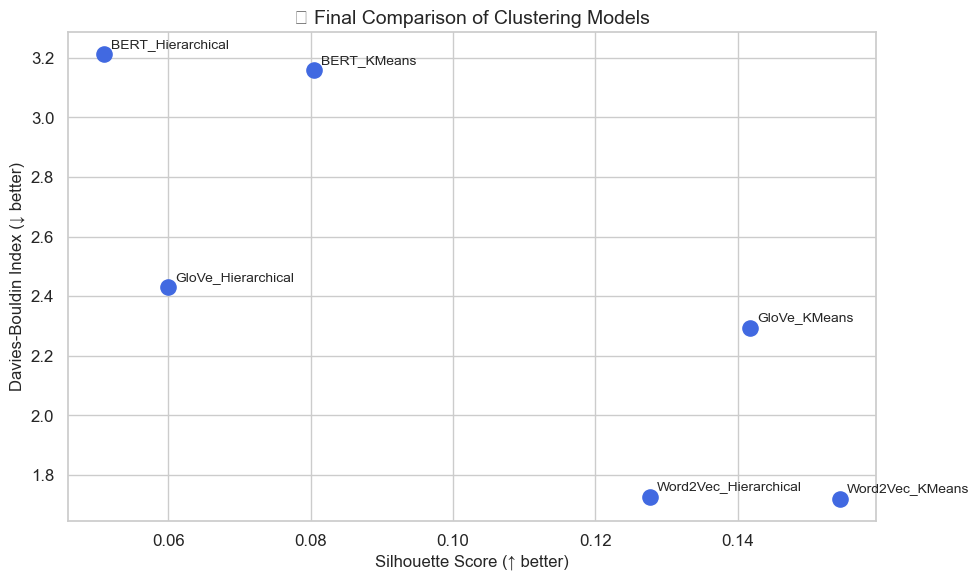

In [206]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the final results
final_results_df = pd.read_csv("model_scores_word2vec_kmeans.csv", header=0)

# Construct model labels
final_results_df["Model"] = final_results_df["Embedding"] + "_" + final_results_df["Clustering"]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(
    final_results_df["Silhouette_Score"],
    final_results_df["Davies_Bouldin_Index"],
    s=120, c='royalblue'
)

# Annotate each point
for i, row in final_results_df.iterrows():
    plt.annotate(
        row["Model"],
        (row["Silhouette_Score"], row["Davies_Bouldin_Index"]),
        textcoords="offset points",
        xytext=(5, 5),
        ha="left",
        fontsize=10
    )

# Axes labels and title
plt.xlabel("Silhouette Score (↑ better)", fontsize=12)
plt.ylabel("Davies-Bouldin Index (↓ better)", fontsize=12)
plt.title("📊 Final Comparison of Clustering Models", fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()
